In [57]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, RandomSampler
from smalldiffusion import (
    TimeInputMLP, ScheduleLogLinear, training_loop, samples,
    DatasaurusDozen, Swissroll
)

def plot_batch(batch):
    batch = batch.cpu().numpy()
    plt.scatter(batch[:,0], batch[:,1], marker='.')

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def last(iterable):
    *_, last = iterable
    return last

Load and plot 2D point data from the [Datasaurus Dozen](https://jumpingrivers.github.io/datasauRus/) dataset. 

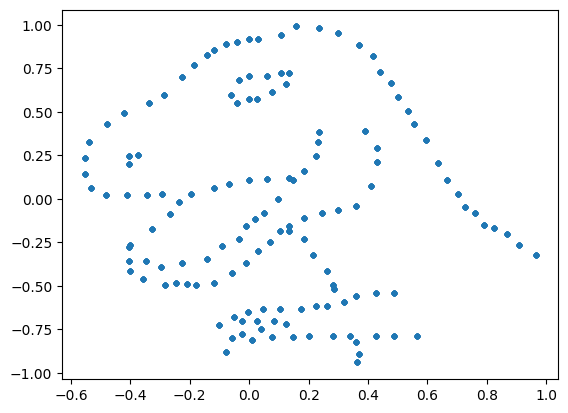

In [43]:
# Try replacing dataset with 'dino', 'bullseye', 'h_lines', 'x_shape', etc. 
dataset = DatasaurusDozen(csv_file='../datasets/DatasaurusDozen.tsv', dataset='dino')
loader = DataLoader(dataset, sampler=RandomSampler(dataset, num_samples=2048), batch_size=2048)
plot_batch(next(iter(loader)))

Use a log-linear $\sigma$ schedule with 200 steps.

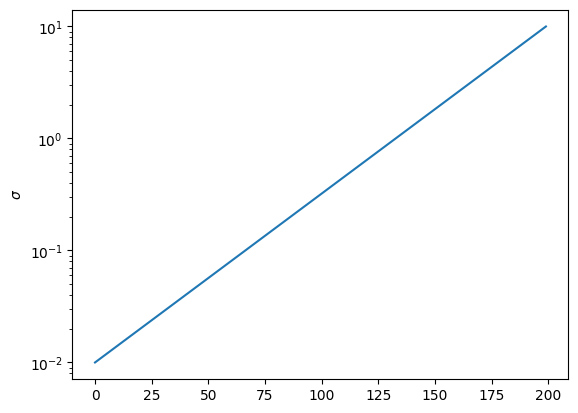

In [44]:
schedule = ScheduleLogLinear(N=200, sigma_min=0.01, sigma_max=10)
plt.plot(schedule._sigmas)
plt.ylabel('$\sigma$')
plt.yscale('log')

The $\sigma$ schedule is embedded sinusoidally as $[\sin(\log(\sigma)/2), \cos(\log(\sigma)/2)]$. 

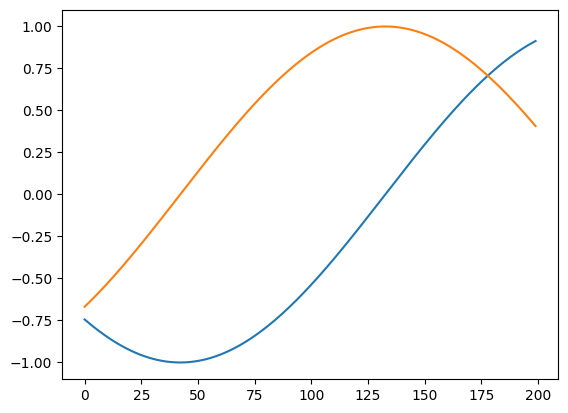

In [45]:
from smalldiffusion.model import get_sigma_embeds
plt.plot(get_sigma_embeds(len(schedule), schedule._sigmas))
plt.show()

Define a simple diffusion model using a MLP. The 4-dimensional input to this MLP
is the $\sigma$ embeddings concatenated with $x$.
The MLP has a 2-dimensional output, the predicted noise $\epsilon$. 

In [46]:
model = TimeInputMLP(hidden_dims=(16,128,128,128,128,16))
print(model)

TimeInputMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=16, out_features=128, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): GELU(approximate='none')
    (10): Linear(in_features=128, out_features=16, bias=True)
    (11): GELU(approximate='none')
    (12): Linear(in_features=16, out_features=2, bias=True)
  )
)


Train the diffusion model and plot training loss

  0%|                                                       | 0/10000 [00:00<?, ?it/s]

  0%|                                               | 9/10000 [00:00<01:55, 86.87it/s]

  0%|                                              | 20/10000 [00:00<01:40, 99.78it/s]

  0%|▏                                            | 33/10000 [00:00<01:30, 110.51it/s]

  0%|▏                                            | 46/10000 [00:00<01:26, 114.65it/s]

  1%|▎                                            | 58/10000 [00:00<01:27, 113.76it/s]

  1%|▎                                            | 70/10000 [00:00<01:28, 111.91it/s]

  1%|▎                                            | 82/10000 [00:00<01:33, 106.08it/s]

  1%|▍                                             | 93/10000 [00:00<01:40, 98.61it/s]

  1%|▍                                            | 103/10000 [00:00<01:41, 97.13it/s]

  1%|▌                                           | 115/10000 [00:01<01:36, 102.03it/s]

  1%|▌                                           | 127/10000 [00:01<01:32, 106.35it/s]

  1%|▌                                           | 140/10000 [00:01<01:28, 110.93it/s]

  2%|▋                                           | 152/10000 [00:01<01:29, 109.47it/s]

  2%|▋                                           | 163/10000 [00:01<01:35, 103.54it/s]

  2%|▊                                            | 174/10000 [00:01<01:38, 99.39it/s]

  2%|▊                                            | 185/10000 [00:01<01:38, 99.36it/s]

  2%|▉                                            | 195/10000 [00:01<01:42, 95.94it/s]

  2%|▉                                           | 207/10000 [00:01<01:36, 101.76it/s]

  2%|▉                                           | 219/10000 [00:02<01:33, 104.37it/s]

  2%|█                                           | 230/10000 [00:02<01:36, 100.92it/s]

  2%|█                                           | 243/10000 [00:02<01:31, 106.47it/s]

  3%|█                                           | 255/10000 [00:02<01:28, 109.57it/s]

  3%|█▏                                          | 267/10000 [00:02<01:29, 109.26it/s]

  3%|█▏                                          | 278/10000 [00:02<01:30, 107.17it/s]

  3%|█▎                                          | 291/10000 [00:02<01:27, 111.57it/s]

  3%|█▎                                          | 303/10000 [00:02<01:26, 112.12it/s]

  3%|█▍                                          | 315/10000 [00:02<01:24, 113.99it/s]

  3%|█▍                                          | 327/10000 [00:03<01:26, 112.47it/s]

  3%|█▍                                          | 340/10000 [00:03<01:23, 115.53it/s]

  4%|█▌                                          | 352/10000 [00:03<01:22, 116.58it/s]

  4%|█▌                                          | 365/10000 [00:03<01:21, 118.52it/s]

  4%|█▋                                          | 377/10000 [00:03<01:22, 116.72it/s]

  4%|█▋                                          | 390/10000 [00:03<01:21, 118.08it/s]

  4%|█▊                                          | 402/10000 [00:03<01:21, 118.44it/s]

  4%|█▊                                          | 414/10000 [00:03<01:20, 118.59it/s]

  4%|█▊                                          | 426/10000 [00:03<01:21, 117.14it/s]

  4%|█▉                                          | 438/10000 [00:04<01:22, 116.15it/s]

  4%|█▉                                          | 450/10000 [00:04<01:22, 116.32it/s]

  5%|██                                          | 462/10000 [00:04<01:24, 113.08it/s]

  5%|██                                          | 475/10000 [00:04<01:21, 116.42it/s]

  5%|██▏                                         | 487/10000 [00:04<01:21, 116.77it/s]

  5%|██▏                                         | 500/10000 [00:04<01:20, 118.16it/s]

  5%|██▎                                         | 512/10000 [00:04<01:20, 118.49it/s]

  5%|██▎                                         | 524/10000 [00:04<01:21, 116.90it/s]

  5%|██▎                                         | 536/10000 [00:04<01:20, 117.19it/s]

  5%|██▍                                         | 548/10000 [00:04<01:20, 117.13it/s]

  6%|██▍                                         | 560/10000 [00:05<01:21, 115.62it/s]

  6%|██▌                                         | 572/10000 [00:05<01:21, 115.57it/s]

  6%|██▌                                         | 584/10000 [00:05<01:20, 116.30it/s]

  6%|██▌                                         | 596/10000 [00:05<01:23, 112.94it/s]

  6%|██▋                                         | 608/10000 [00:05<01:22, 113.98it/s]

  6%|██▋                                         | 620/10000 [00:05<01:25, 109.46it/s]

  6%|██▊                                         | 632/10000 [00:05<01:24, 111.11it/s]

  6%|██▊                                         | 644/10000 [00:05<01:27, 107.15it/s]

  7%|██▉                                         | 655/10000 [00:05<01:27, 107.26it/s]

  7%|██▉                                         | 667/10000 [00:06<01:24, 110.23it/s]

  7%|██▉                                         | 679/10000 [00:06<01:23, 111.87it/s]

  7%|███                                         | 691/10000 [00:06<01:22, 113.38it/s]

  7%|███                                         | 703/10000 [00:06<01:20, 114.82it/s]

  7%|███▏                                        | 715/10000 [00:06<01:20, 115.95it/s]

  7%|███▏                                        | 727/10000 [00:06<01:27, 106.24it/s]

  7%|███▏                                        | 738/10000 [00:06<01:27, 105.63it/s]

  7%|███▎                                        | 749/10000 [00:06<01:29, 103.62it/s]

  8%|███▎                                        | 761/10000 [00:06<01:26, 106.71it/s]

  8%|███▍                                        | 773/10000 [00:07<01:25, 108.06it/s]

  8%|███▍                                        | 785/10000 [00:07<01:24, 108.78it/s]

  8%|███▌                                        | 798/10000 [00:07<01:21, 112.51it/s]

  8%|███▌                                        | 811/10000 [00:07<01:19, 115.35it/s]

  8%|███▌                                        | 823/10000 [00:07<01:21, 112.65it/s]

  8%|███▋                                        | 835/10000 [00:07<01:20, 113.65it/s]

  8%|███▋                                        | 847/10000 [00:07<01:19, 114.89it/s]

  9%|███▊                                        | 859/10000 [00:07<01:18, 116.11it/s]

  9%|███▊                                        | 872/10000 [00:07<01:17, 117.71it/s]

  9%|███▉                                        | 884/10000 [00:07<01:18, 116.35it/s]

  9%|███▉                                        | 896/10000 [00:08<01:20, 112.91it/s]

  9%|███▉                                        | 908/10000 [00:08<01:20, 113.63it/s]

  9%|████                                        | 920/10000 [00:08<01:19, 114.89it/s]

  9%|████                                        | 932/10000 [00:08<01:18, 114.89it/s]

  9%|████▏                                       | 944/10000 [00:08<01:19, 114.35it/s]

 10%|████▏                                       | 956/10000 [00:08<01:25, 105.88it/s]

 10%|████▎                                       | 967/10000 [00:08<01:27, 103.49it/s]

 10%|████▎                                       | 979/10000 [00:08<01:24, 107.24it/s]

 10%|████▎                                       | 991/10000 [00:08<01:22, 108.79it/s]

 10%|████▎                                      | 1002/10000 [00:09<01:25, 105.39it/s]

 10%|████▎                                      | 1014/10000 [00:09<01:23, 107.98it/s]

 10%|████▍                                      | 1026/10000 [00:09<01:22, 109.29it/s]

 10%|████▍                                      | 1037/10000 [00:09<01:22, 109.11it/s]

 10%|████▌                                      | 1049/10000 [00:09<01:20, 110.65it/s]

 11%|████▌                                      | 1061/10000 [00:09<01:23, 106.78it/s]

 11%|████▌                                      | 1072/10000 [00:09<01:26, 103.25it/s]

 11%|████▋                                      | 1083/10000 [00:09<01:25, 104.87it/s]

 11%|████▋                                      | 1094/10000 [00:09<01:26, 103.26it/s]

 11%|████▊                                      | 1105/10000 [00:10<01:26, 102.33it/s]

 11%|████▊                                      | 1117/10000 [00:10<01:23, 105.79it/s]

 11%|████▊                                      | 1128/10000 [00:10<01:25, 103.98it/s]

 11%|████▉                                      | 1139/10000 [00:10<01:25, 103.31it/s]

 12%|████▉                                      | 1152/10000 [00:10<01:21, 108.53it/s]

 12%|█████                                      | 1164/10000 [00:10<01:19, 110.48it/s]

 12%|█████                                      | 1176/10000 [00:10<01:23, 105.87it/s]

 12%|█████                                      | 1187/10000 [00:10<01:23, 105.37it/s]

 12%|█████▏                                     | 1198/10000 [00:10<01:23, 105.28it/s]

 12%|█████▏                                     | 1210/10000 [00:11<01:20, 108.68it/s]

 12%|█████▎                                     | 1222/10000 [00:11<01:19, 110.97it/s]

 12%|█████▎                                     | 1234/10000 [00:11<01:20, 108.94it/s]

 12%|█████▎                                     | 1245/10000 [00:11<01:23, 105.17it/s]

 13%|█████▍                                     | 1256/10000 [00:11<01:26, 101.50it/s]

 13%|█████▌                                      | 1267/10000 [00:11<01:30, 96.57it/s]

 13%|█████▌                                      | 1277/10000 [00:11<01:33, 93.31it/s]

 13%|█████▋                                      | 1287/10000 [00:11<01:36, 90.25it/s]

 13%|█████▋                                      | 1297/10000 [00:11<01:38, 88.29it/s]

 13%|█████▋                                      | 1306/10000 [00:12<01:42, 84.71it/s]

 13%|█████▊                                      | 1315/10000 [00:12<01:43, 83.83it/s]

 13%|█████▊                                      | 1324/10000 [00:12<01:45, 82.38it/s]

 13%|█████▊                                      | 1333/10000 [00:12<01:50, 78.16it/s]

 13%|█████▉                                      | 1341/10000 [00:12<01:53, 76.19it/s]

 14%|█████▉                                      | 1350/10000 [00:12<01:50, 78.11it/s]

 14%|█████▉                                      | 1359/10000 [00:12<01:48, 79.36it/s]

 14%|██████                                      | 1367/10000 [00:12<01:53, 75.78it/s]

 14%|██████                                      | 1375/10000 [00:12<01:55, 74.37it/s]

 14%|██████                                      | 1383/10000 [00:13<01:57, 73.23it/s]

 14%|██████                                      | 1392/10000 [00:13<01:53, 76.00it/s]

 14%|██████▏                                     | 1400/10000 [00:13<01:53, 75.57it/s]

 14%|██████▏                                     | 1408/10000 [00:13<01:53, 75.58it/s]

 14%|██████▏                                     | 1416/10000 [00:13<01:52, 76.01it/s]

 14%|██████▎                                     | 1425/10000 [00:13<01:48, 78.76it/s]

 14%|██████▎                                     | 1434/10000 [00:13<01:46, 80.08it/s]

 14%|██████▎                                     | 1443/10000 [00:13<01:47, 79.70it/s]

 15%|██████▍                                     | 1452/10000 [00:13<01:45, 80.94it/s]

 15%|██████▍                                     | 1461/10000 [00:14<01:47, 79.21it/s]

 15%|██████▍                                     | 1470/10000 [00:14<01:45, 80.89it/s]

 15%|██████▌                                     | 1479/10000 [00:14<01:43, 82.06it/s]

 15%|██████▌                                     | 1488/10000 [00:14<01:41, 84.09it/s]

 15%|██████▌                                     | 1497/10000 [00:14<01:39, 85.57it/s]

 15%|██████▋                                     | 1506/10000 [00:14<01:38, 86.37it/s]

 15%|██████▋                                     | 1515/10000 [00:14<01:39, 85.47it/s]

 15%|██████▋                                     | 1524/10000 [00:14<01:39, 85.38it/s]

 15%|██████▋                                     | 1533/10000 [00:14<01:42, 82.50it/s]

 15%|██████▊                                     | 1542/10000 [00:15<01:48, 77.75it/s]

 16%|██████▊                                     | 1550/10000 [00:15<01:49, 77.21it/s]

 16%|██████▊                                     | 1559/10000 [00:15<01:47, 78.86it/s]

 16%|██████▉                                     | 1568/10000 [00:15<01:45, 79.92it/s]

 16%|██████▉                                     | 1577/10000 [00:15<01:45, 79.83it/s]

 16%|██████▉                                     | 1586/10000 [00:15<01:42, 82.29it/s]

 16%|███████                                     | 1595/10000 [00:15<01:48, 77.50it/s]

 16%|███████                                     | 1603/10000 [00:15<01:47, 77.96it/s]

 16%|███████                                     | 1611/10000 [00:15<01:54, 73.29it/s]

 16%|███████                                     | 1619/10000 [00:16<01:54, 73.17it/s]

 16%|███████▏                                    | 1628/10000 [00:16<01:47, 77.77it/s]

 16%|███████▏                                    | 1637/10000 [00:16<01:43, 81.18it/s]

 16%|███████▏                                    | 1646/10000 [00:16<01:40, 83.31it/s]

 17%|███████▎                                    | 1655/10000 [00:16<01:39, 83.94it/s]

 17%|███████▎                                    | 1664/10000 [00:16<01:39, 84.01it/s]

 17%|███████▎                                    | 1673/10000 [00:16<01:37, 85.48it/s]

 17%|███████▍                                    | 1682/10000 [00:16<01:36, 86.26it/s]

 17%|███████▍                                    | 1691/10000 [00:16<01:36, 85.88it/s]

 17%|███████▍                                    | 1700/10000 [00:16<01:37, 85.53it/s]

 17%|███████▌                                    | 1709/10000 [00:17<01:36, 85.52it/s]

 17%|███████▌                                    | 1718/10000 [00:17<01:36, 85.74it/s]

 17%|███████▌                                    | 1727/10000 [00:17<01:39, 82.80it/s]

 17%|███████▋                                    | 1736/10000 [00:17<01:42, 80.54it/s]

 17%|███████▋                                    | 1745/10000 [00:17<01:45, 78.24it/s]

 18%|███████▋                                    | 1754/10000 [00:17<01:43, 79.79it/s]

 18%|███████▊                                    | 1763/10000 [00:17<01:40, 81.96it/s]

 18%|███████▊                                    | 1772/10000 [00:17<01:39, 82.39it/s]

 18%|███████▊                                    | 1781/10000 [00:17<01:47, 76.56it/s]

 18%|███████▊                                    | 1789/10000 [00:18<01:53, 72.26it/s]

 18%|███████▉                                    | 1797/10000 [00:18<01:57, 69.78it/s]

 18%|███████▉                                    | 1805/10000 [00:18<01:55, 70.96it/s]

 18%|███████▉                                    | 1813/10000 [00:18<01:56, 70.24it/s]

 18%|████████                                    | 1821/10000 [00:18<01:54, 71.29it/s]

 18%|████████                                    | 1830/10000 [00:18<01:48, 75.00it/s]

 18%|████████                                    | 1838/10000 [00:18<01:51, 73.34it/s]

 18%|████████                                    | 1846/10000 [00:18<01:51, 73.42it/s]

 19%|████████▏                                   | 1854/10000 [00:19<01:51, 72.96it/s]

 19%|████████▏                                   | 1862/10000 [00:19<01:50, 73.87it/s]

 19%|████████▏                                   | 1871/10000 [00:19<01:46, 76.34it/s]

 19%|████████▎                                   | 1879/10000 [00:19<01:48, 74.84it/s]

 19%|████████▎                                   | 1888/10000 [00:19<01:44, 77.61it/s]

 19%|████████▎                                   | 1896/10000 [00:19<01:51, 72.56it/s]

 19%|████████▍                                   | 1905/10000 [00:19<01:45, 76.67it/s]

 19%|████████▍                                   | 1914/10000 [00:19<01:43, 78.42it/s]

 19%|████████▍                                   | 1922/10000 [00:19<01:43, 77.94it/s]

 19%|████████▍                                   | 1930/10000 [00:20<01:46, 75.84it/s]

 19%|████████▌                                   | 1939/10000 [00:20<01:42, 78.33it/s]

 19%|████████▌                                   | 1947/10000 [00:20<01:42, 78.39it/s]

 20%|████████▌                                   | 1955/10000 [00:20<01:44, 76.68it/s]

 20%|████████▋                                   | 1963/10000 [00:20<01:45, 76.07it/s]

 20%|████████▋                                   | 1971/10000 [00:20<01:44, 77.01it/s]

 20%|████████▋                                   | 1979/10000 [00:20<01:50, 72.39it/s]

 20%|████████▋                                   | 1987/10000 [00:20<01:48, 73.64it/s]

 20%|████████▊                                   | 1996/10000 [00:20<01:44, 76.57it/s]

 20%|████████▊                                   | 2004/10000 [00:20<01:43, 77.08it/s]

 20%|████████▊                                   | 2013/10000 [00:21<01:41, 78.98it/s]

 20%|████████▉                                   | 2022/10000 [00:21<01:37, 81.66it/s]

 20%|████████▉                                   | 2031/10000 [00:21<01:36, 82.52it/s]

 20%|████████▉                                   | 2040/10000 [00:21<01:36, 82.73it/s]

 20%|█████████                                   | 2049/10000 [00:21<01:35, 83.06it/s]

 21%|█████████                                   | 2058/10000 [00:21<01:35, 83.16it/s]

 21%|█████████                                   | 2067/10000 [00:21<01:34, 84.27it/s]

 21%|█████████▏                                  | 2076/10000 [00:21<01:36, 81.99it/s]

 21%|█████████▏                                  | 2085/10000 [00:21<01:38, 79.98it/s]

 21%|█████████▏                                  | 2094/10000 [00:22<01:38, 80.38it/s]

 21%|█████████▎                                  | 2103/10000 [00:22<01:36, 82.14it/s]

 21%|█████████▎                                  | 2112/10000 [00:22<01:37, 81.25it/s]

 21%|█████████▎                                  | 2121/10000 [00:22<01:46, 74.15it/s]

 21%|█████████▎                                  | 2129/10000 [00:22<01:49, 71.81it/s]

 21%|█████████▍                                  | 2138/10000 [00:22<01:43, 75.86it/s]

 21%|█████████▍                                  | 2147/10000 [00:22<01:40, 78.03it/s]

 22%|█████████▍                                  | 2155/10000 [00:22<01:43, 75.45it/s]

 22%|█████████▌                                  | 2163/10000 [00:23<01:47, 72.68it/s]

 22%|█████████▌                                  | 2171/10000 [00:23<01:48, 71.88it/s]

 22%|█████████▌                                  | 2179/10000 [00:23<01:47, 72.82it/s]

 22%|█████████▋                                  | 2188/10000 [00:23<01:43, 75.73it/s]

 22%|█████████▋                                  | 2197/10000 [00:23<01:41, 76.77it/s]

 22%|█████████▋                                  | 2205/10000 [00:23<01:40, 77.23it/s]

 22%|█████████▋                                  | 2214/10000 [00:23<01:39, 78.55it/s]

 22%|█████████▊                                  | 2222/10000 [00:23<01:42, 75.57it/s]

 22%|█████████▊                                  | 2230/10000 [00:23<01:41, 76.52it/s]

 22%|█████████▊                                  | 2238/10000 [00:23<01:43, 74.68it/s]

 22%|█████████▉                                  | 2246/10000 [00:24<01:42, 75.30it/s]

 23%|█████████▉                                  | 2255/10000 [00:24<01:38, 78.34it/s]

 23%|█████████▉                                  | 2264/10000 [00:24<01:36, 80.16it/s]

 23%|██████████                                  | 2273/10000 [00:24<01:33, 82.36it/s]

 23%|██████████                                  | 2282/10000 [00:24<01:33, 82.94it/s]

 23%|██████████                                  | 2291/10000 [00:24<01:32, 83.09it/s]

 23%|██████████                                  | 2300/10000 [00:24<01:36, 79.94it/s]

 23%|██████████▏                                 | 2309/10000 [00:24<01:40, 76.56it/s]

 23%|██████████▏                                 | 2317/10000 [00:25<01:49, 70.48it/s]

 23%|██████████▏                                 | 2325/10000 [00:25<01:53, 67.69it/s]

 23%|██████████▎                                 | 2332/10000 [00:25<01:55, 66.59it/s]

 23%|██████████▎                                 | 2339/10000 [00:25<01:58, 64.88it/s]

 23%|██████████▎                                 | 2346/10000 [00:25<02:01, 62.80it/s]

 24%|██████████▎                                 | 2354/10000 [00:25<01:54, 67.05it/s]

 24%|██████████▍                                 | 2362/10000 [00:25<01:51, 68.54it/s]

 24%|██████████▍                                 | 2370/10000 [00:25<01:47, 71.04it/s]

 24%|██████████▍                                 | 2378/10000 [00:25<01:45, 72.22it/s]

 24%|██████████▍                                 | 2386/10000 [00:26<01:50, 68.80it/s]

 24%|██████████▌                                 | 2395/10000 [00:26<01:44, 72.67it/s]

 24%|██████████▌                                 | 2404/10000 [00:26<01:39, 76.00it/s]

 24%|██████████▌                                 | 2412/10000 [00:26<01:38, 77.02it/s]

 24%|██████████▋                                 | 2420/10000 [00:26<01:39, 76.24it/s]

 24%|██████████▋                                 | 2429/10000 [00:26<01:37, 77.90it/s]

 24%|██████████▋                                 | 2438/10000 [00:26<01:34, 80.00it/s]

 24%|██████████▊                                 | 2447/10000 [00:26<01:31, 82.32it/s]

 25%|██████████▊                                 | 2456/10000 [00:26<01:32, 81.96it/s]

 25%|██████████▊                                 | 2465/10000 [00:27<01:36, 78.16it/s]

 25%|██████████▉                                 | 2473/10000 [00:27<01:39, 75.69it/s]

 25%|██████████▉                                 | 2482/10000 [00:27<01:37, 77.38it/s]

 25%|██████████▉                                 | 2490/10000 [00:27<01:36, 77.65it/s]

 25%|██████████▉                                 | 2499/10000 [00:27<01:34, 79.45it/s]

 25%|███████████                                 | 2508/10000 [00:27<01:31, 81.61it/s]

 25%|███████████                                 | 2517/10000 [00:27<01:31, 81.51it/s]

 25%|███████████                                 | 2526/10000 [00:27<01:30, 83.04it/s]

 25%|███████████▏                                | 2535/10000 [00:27<01:30, 82.60it/s]

 25%|███████████▏                                | 2544/10000 [00:27<01:30, 82.73it/s]

 26%|███████████▏                                | 2553/10000 [00:28<01:31, 81.82it/s]

 26%|███████████▎                                | 2562/10000 [00:28<01:29, 83.07it/s]

 26%|███████████▎                                | 2571/10000 [00:28<01:28, 83.60it/s]

 26%|███████████▎                                | 2580/10000 [00:28<01:27, 85.23it/s]

 26%|███████████▍                                | 2589/10000 [00:28<01:26, 85.33it/s]

 26%|███████████▍                                | 2598/10000 [00:28<01:25, 86.14it/s]

 26%|███████████▍                                | 2607/10000 [00:28<01:25, 86.97it/s]

 26%|███████████▌                                | 2616/10000 [00:28<01:24, 87.07it/s]

 26%|███████████▌                                | 2625/10000 [00:28<01:29, 82.21it/s]

 26%|███████████▌                                | 2634/10000 [00:29<01:36, 76.16it/s]

 26%|███████████▋                                | 2643/10000 [00:29<01:34, 77.68it/s]

 27%|███████████▋                                | 2651/10000 [00:29<01:35, 76.62it/s]

 27%|███████████▋                                | 2661/10000 [00:29<01:30, 81.47it/s]

 27%|███████████▋                                | 2670/10000 [00:29<01:27, 83.81it/s]

 27%|███████████▊                                | 2679/10000 [00:29<01:26, 84.44it/s]

 27%|███████████▊                                | 2688/10000 [00:29<01:28, 82.49it/s]

 27%|███████████▊                                | 2697/10000 [00:29<01:33, 77.94it/s]

 27%|███████████▉                                | 2705/10000 [00:29<01:39, 73.23it/s]

 27%|███████████▉                                | 2714/10000 [00:30<01:35, 76.33it/s]

 27%|███████████▉                                | 2723/10000 [00:30<01:32, 79.08it/s]

 27%|████████████                                | 2732/10000 [00:30<01:30, 80.71it/s]

 27%|████████████                                | 2741/10000 [00:30<01:27, 82.75it/s]

 28%|████████████                                | 2751/10000 [00:30<01:24, 85.44it/s]

 28%|████████████▏                               | 2760/10000 [00:30<01:27, 82.43it/s]

 28%|████████████▏                               | 2769/10000 [00:30<01:28, 81.62it/s]

 28%|████████████▏                               | 2778/10000 [00:30<01:28, 81.93it/s]

 28%|████████████▎                               | 2787/10000 [00:30<01:31, 79.10it/s]

 28%|████████████▎                               | 2795/10000 [00:31<01:37, 73.52it/s]

 28%|████████████▎                               | 2803/10000 [00:31<01:39, 72.47it/s]

 28%|████████████▎                               | 2811/10000 [00:31<01:38, 73.36it/s]

 28%|████████████▍                               | 2819/10000 [00:31<01:41, 70.81it/s]

 28%|████████████▍                               | 2827/10000 [00:31<01:41, 70.50it/s]

 28%|████████████▍                               | 2836/10000 [00:31<01:35, 75.27it/s]

 28%|████████████▌                               | 2844/10000 [00:31<01:34, 75.88it/s]

 29%|████████████▌                               | 2852/10000 [00:31<01:35, 74.87it/s]

 29%|████████████▌                               | 2861/10000 [00:31<01:32, 76.98it/s]

 29%|████████████▌                               | 2869/10000 [00:32<01:31, 77.60it/s]

 29%|████████████▋                               | 2878/10000 [00:32<01:29, 79.54it/s]

 29%|████████████▋                               | 2886/10000 [00:32<01:32, 77.00it/s]

 29%|████████████▋                               | 2894/10000 [00:32<01:31, 77.38it/s]

 29%|████████████▊                               | 2902/10000 [00:32<01:37, 73.05it/s]

 29%|████████████▊                               | 2910/10000 [00:32<01:36, 73.27it/s]

 29%|████████████▊                               | 2918/10000 [00:32<01:34, 74.90it/s]

 29%|████████████▊                               | 2926/10000 [00:32<01:35, 73.98it/s]

 29%|████████████▉                               | 2934/10000 [00:32<01:39, 70.70it/s]

 29%|████████████▉                               | 2942/10000 [00:33<01:37, 72.73it/s]

 30%|████████████▉                               | 2951/10000 [00:33<01:31, 77.36it/s]

 30%|█████████████                               | 2959/10000 [00:33<01:31, 77.08it/s]

 30%|█████████████                               | 2967/10000 [00:33<01:32, 76.09it/s]

 30%|█████████████                               | 2975/10000 [00:33<01:33, 75.20it/s]

 30%|█████████████▏                              | 2983/10000 [00:33<01:31, 76.50it/s]

 30%|█████████████▏                              | 2992/10000 [00:33<01:27, 80.35it/s]

 30%|█████████████▏                              | 3001/10000 [00:33<01:25, 81.85it/s]

 30%|█████████████▏                              | 3010/10000 [00:33<01:24, 82.24it/s]

 30%|█████████████▎                              | 3019/10000 [00:34<01:29, 78.27it/s]

 30%|█████████████▎                              | 3028/10000 [00:34<01:26, 80.47it/s]

 30%|█████████████▎                              | 3037/10000 [00:34<01:25, 81.18it/s]

 30%|█████████████▍                              | 3046/10000 [00:34<01:27, 79.89it/s]

 31%|█████████████▍                              | 3055/10000 [00:34<01:29, 77.60it/s]

 31%|█████████████▍                              | 3063/10000 [00:34<01:30, 76.43it/s]

 31%|█████████████▌                              | 3071/10000 [00:34<01:29, 77.37it/s]

 31%|█████████████▌                              | 3080/10000 [00:34<01:27, 78.86it/s]

 31%|█████████████▌                              | 3089/10000 [00:34<01:27, 79.30it/s]

 31%|█████████████▋                              | 3098/10000 [00:35<01:26, 79.64it/s]

 31%|█████████████▋                              | 3107/10000 [00:35<01:25, 80.57it/s]

 31%|█████████████▋                              | 3116/10000 [00:35<01:31, 75.53it/s]

 31%|█████████████▋                              | 3124/10000 [00:35<01:33, 73.16it/s]

 31%|█████████████▊                              | 3132/10000 [00:35<01:32, 74.12it/s]

 31%|█████████████▊                              | 3140/10000 [00:35<01:34, 72.49it/s]

 31%|█████████████▊                              | 3148/10000 [00:35<01:33, 72.91it/s]

 32%|█████████████▉                              | 3156/10000 [00:35<01:36, 71.26it/s]

 32%|█████████████▉                              | 3164/10000 [00:35<01:34, 72.38it/s]

 32%|█████████████▉                              | 3172/10000 [00:36<01:31, 74.32it/s]

 32%|█████████████▉                              | 3180/10000 [00:36<01:33, 72.80it/s]

 32%|██████████████                              | 3188/10000 [00:36<01:35, 71.13it/s]

 32%|██████████████                              | 3196/10000 [00:36<01:34, 72.05it/s]

 32%|██████████████                              | 3204/10000 [00:36<01:32, 73.66it/s]

 32%|██████████████▏                             | 3212/10000 [00:36<01:36, 70.70it/s]

 32%|██████████████▏                             | 3220/10000 [00:36<01:38, 68.62it/s]

 32%|██████████████▏                             | 3229/10000 [00:36<01:33, 72.64it/s]

 32%|██████████████▏                             | 3237/10000 [00:36<01:31, 74.27it/s]

 32%|██████████████▎                             | 3245/10000 [00:37<01:32, 73.09it/s]

 33%|██████████████▎                             | 3253/10000 [00:37<01:32, 72.74it/s]

 33%|██████████████▎                             | 3261/10000 [00:37<01:31, 74.02it/s]

 33%|██████████████▍                             | 3269/10000 [00:37<01:31, 73.72it/s]

 33%|██████████████▍                             | 3277/10000 [00:37<01:31, 73.41it/s]

 33%|██████████████▍                             | 3285/10000 [00:37<01:31, 73.62it/s]

 33%|██████████████▍                             | 3293/10000 [00:37<01:35, 70.11it/s]

 33%|██████████████▌                             | 3301/10000 [00:37<01:35, 69.88it/s]

 33%|██████████████▌                             | 3309/10000 [00:37<01:35, 70.16it/s]

 33%|██████████████▌                             | 3317/10000 [00:38<01:35, 70.24it/s]

 33%|██████████████▋                             | 3325/10000 [00:38<01:36, 69.09it/s]

 33%|██████████████▋                             | 3332/10000 [00:38<01:40, 66.48it/s]

 33%|██████████████▋                             | 3339/10000 [00:38<01:41, 65.95it/s]

 33%|██████████████▋                             | 3348/10000 [00:38<01:34, 70.74it/s]

 34%|██████████████▊                             | 3356/10000 [00:38<01:31, 72.24it/s]

 34%|██████████████▊                             | 3364/10000 [00:38<01:32, 72.11it/s]

 34%|██████████████▊                             | 3372/10000 [00:38<01:34, 70.40it/s]

 34%|██████████████▊                             | 3380/10000 [00:39<01:33, 70.48it/s]

 34%|██████████████▉                             | 3388/10000 [00:39<01:31, 71.95it/s]

 34%|██████████████▉                             | 3397/10000 [00:39<01:28, 74.84it/s]

 34%|██████████████▉                             | 3405/10000 [00:39<01:29, 74.07it/s]

 34%|███████████████                             | 3413/10000 [00:39<01:28, 74.09it/s]

 34%|███████████████                             | 3421/10000 [00:39<01:27, 75.46it/s]

 34%|███████████████                             | 3430/10000 [00:39<01:24, 77.66it/s]

 34%|███████████████▏                            | 3438/10000 [00:39<01:24, 77.37it/s]

 34%|███████████████▏                            | 3446/10000 [00:39<01:26, 75.53it/s]

 35%|███████████████▏                            | 3455/10000 [00:39<01:23, 77.96it/s]

 35%|███████████████▏                            | 3464/10000 [00:40<01:20, 81.27it/s]

 35%|███████████████▎                            | 3473/10000 [00:40<01:18, 83.66it/s]

 35%|███████████████▎                            | 3482/10000 [00:40<01:21, 79.63it/s]

 35%|███████████████▎                            | 3491/10000 [00:40<01:30, 71.68it/s]

 35%|███████████████▍                            | 3499/10000 [00:40<01:32, 70.58it/s]

 35%|███████████████▍                            | 3507/10000 [00:40<01:36, 67.04it/s]

 35%|███████████████▍                            | 3514/10000 [00:40<01:41, 64.08it/s]

 35%|███████████████▍                            | 3521/10000 [00:40<01:42, 63.07it/s]

 35%|███████████████▌                            | 3528/10000 [00:41<01:43, 62.80it/s]

 35%|███████████████▌                            | 3536/10000 [00:41<01:36, 67.23it/s]

 35%|███████████████▌                            | 3543/10000 [00:41<01:37, 66.21it/s]

 36%|███████████████▌                            | 3550/10000 [00:41<01:36, 66.77it/s]

 36%|███████████████▋                            | 3557/10000 [00:41<01:38, 65.53it/s]

 36%|███████████████▋                            | 3565/10000 [00:41<01:34, 68.32it/s]

 36%|███████████████▋                            | 3574/10000 [00:41<01:26, 74.20it/s]

 36%|███████████████▊                            | 3582/10000 [00:41<01:28, 72.68it/s]

 36%|███████████████▊                            | 3591/10000 [00:41<01:24, 76.29it/s]

 36%|███████████████▊                            | 3600/10000 [00:42<01:21, 78.86it/s]

 36%|███████████████▉                            | 3608/10000 [00:42<01:26, 73.70it/s]

 36%|███████████████▉                            | 3616/10000 [00:42<01:31, 69.57it/s]

 36%|███████████████▉                            | 3624/10000 [00:42<01:33, 68.10it/s]

 36%|███████████████▉                            | 3631/10000 [00:42<01:36, 65.91it/s]

 36%|████████████████                            | 3638/10000 [00:42<01:36, 65.64it/s]

 36%|████████████████                            | 3645/10000 [00:42<01:39, 63.96it/s]

 37%|████████████████                            | 3652/10000 [00:42<01:38, 64.27it/s]

 37%|████████████████                            | 3661/10000 [00:42<01:30, 70.39it/s]

 37%|████████████████▏                           | 3670/10000 [00:43<01:24, 74.67it/s]

 37%|████████████████▏                           | 3679/10000 [00:43<01:20, 78.73it/s]

 37%|████████████████▏                           | 3688/10000 [00:43<01:18, 79.96it/s]

 37%|████████████████▎                           | 3697/10000 [00:43<01:17, 81.55it/s]

 37%|████████████████▎                           | 3706/10000 [00:43<01:17, 81.74it/s]

 37%|████████████████▎                           | 3715/10000 [00:43<01:16, 82.31it/s]

 37%|████████████████▍                           | 3724/10000 [00:43<01:16, 81.92it/s]

 37%|████████████████▍                           | 3733/10000 [00:43<01:19, 78.37it/s]

 37%|████████████████▍                           | 3741/10000 [00:43<01:25, 72.95it/s]

 37%|████████████████▍                           | 3749/10000 [00:44<01:27, 71.82it/s]

 38%|████████████████▌                           | 3757/10000 [00:44<01:26, 71.84it/s]

 38%|████████████████▌                           | 3766/10000 [00:44<01:22, 75.19it/s]

 38%|████████████████▌                           | 3775/10000 [00:44<01:20, 77.43it/s]

 38%|████████████████▋                           | 3784/10000 [00:44<01:18, 79.07it/s]

 38%|████████████████▋                           | 3793/10000 [00:44<01:16, 80.73it/s]

 38%|████████████████▋                           | 3802/10000 [00:44<01:16, 80.96it/s]

 38%|████████████████▊                           | 3811/10000 [00:44<01:22, 75.09it/s]

 38%|████████████████▊                           | 3819/10000 [00:44<01:23, 74.34it/s]

 38%|████████████████▊                           | 3828/10000 [00:45<01:20, 76.82it/s]

 38%|████████████████▉                           | 3837/10000 [00:45<01:18, 78.36it/s]

 38%|████████████████▉                           | 3846/10000 [00:45<01:16, 79.95it/s]

 39%|████████████████▉                           | 3855/10000 [00:45<01:18, 77.86it/s]

 39%|████████████████▉                           | 3863/10000 [00:45<01:21, 75.56it/s]

 39%|█████████████████                           | 3871/10000 [00:45<01:26, 70.81it/s]

 39%|█████████████████                           | 3879/10000 [00:45<01:24, 72.48it/s]

 39%|█████████████████                           | 3887/10000 [00:45<01:22, 74.31it/s]

 39%|█████████████████▏                          | 3895/10000 [00:45<01:24, 71.89it/s]

 39%|█████████████████▏                          | 3903/10000 [00:46<01:28, 69.12it/s]

 39%|█████████████████▏                          | 3910/10000 [00:46<01:33, 65.07it/s]

 39%|█████████████████▏                          | 3917/10000 [00:46<01:32, 65.55it/s]

 39%|█████████████████▎                          | 3924/10000 [00:46<01:32, 66.04it/s]

 39%|█████████████████▎                          | 3932/10000 [00:46<01:26, 69.85it/s]

 39%|█████████████████▎                          | 3942/10000 [00:46<01:18, 76.87it/s]

 40%|█████████████████▍                          | 3951/10000 [00:46<01:15, 79.69it/s]

 40%|█████████████████▍                          | 3960/10000 [00:46<01:14, 81.58it/s]

 40%|█████████████████▍                          | 3969/10000 [00:46<01:15, 79.50it/s]

 40%|█████████████████▌                          | 3978/10000 [00:47<01:15, 79.91it/s]

 40%|█████████████████▌                          | 3987/10000 [00:47<01:20, 74.69it/s]

 40%|█████████████████▌                          | 3995/10000 [00:47<01:24, 70.87it/s]

 40%|█████████████████▌                          | 4003/10000 [00:47<01:23, 72.14it/s]

 40%|█████████████████▋                          | 4011/10000 [00:47<01:25, 70.41it/s]

 40%|█████████████████▋                          | 4019/10000 [00:47<01:26, 68.94it/s]

 40%|█████████████████▋                          | 4026/10000 [00:47<01:30, 65.77it/s]

 40%|█████████████████▋                          | 4033/10000 [00:47<01:33, 63.58it/s]

 40%|█████████████████▊                          | 4040/10000 [00:48<01:36, 61.88it/s]

 40%|█████████████████▊                          | 4047/10000 [00:48<01:36, 61.41it/s]

 41%|█████████████████▊                          | 4054/10000 [00:48<01:37, 60.84it/s]

 41%|█████████████████▊                          | 4061/10000 [00:48<01:38, 60.03it/s]

 41%|█████████████████▉                          | 4068/10000 [00:48<01:34, 62.60it/s]

 41%|█████████████████▉                          | 4075/10000 [00:48<01:33, 63.22it/s]

 41%|█████████████████▉                          | 4082/10000 [00:48<01:32, 63.79it/s]

 41%|█████████████████▉                          | 4089/10000 [00:48<01:36, 60.95it/s]

 41%|██████████████████                          | 4096/10000 [00:48<01:36, 61.25it/s]

 41%|██████████████████                          | 4104/10000 [00:49<01:30, 65.44it/s]

 41%|██████████████████                          | 4112/10000 [00:49<01:26, 68.09it/s]

 41%|██████████████████                          | 4119/10000 [00:49<01:28, 66.71it/s]

 41%|██████████████████▏                         | 4127/10000 [00:49<01:24, 69.74it/s]

 41%|██████████████████▏                         | 4136/10000 [00:49<01:18, 74.39it/s]

 41%|██████████████████▏                         | 4145/10000 [00:49<01:16, 76.66it/s]

 42%|██████████████████▎                         | 4154/10000 [00:49<01:12, 80.11it/s]

 42%|██████████████████▎                         | 4163/10000 [00:49<01:13, 79.57it/s]

 42%|██████████████████▎                         | 4171/10000 [00:49<01:13, 79.40it/s]

 42%|██████████████████▍                         | 4179/10000 [00:50<01:14, 78.66it/s]

 42%|██████████████████▍                         | 4188/10000 [00:50<01:13, 79.14it/s]

 42%|██████████████████▍                         | 4197/10000 [00:50<01:11, 81.35it/s]

 42%|██████████████████▌                         | 4206/10000 [00:50<01:15, 77.17it/s]

 42%|██████████████████▌                         | 4214/10000 [00:50<01:17, 74.87it/s]

 42%|██████████████████▌                         | 4222/10000 [00:50<01:18, 73.35it/s]

 42%|██████████████████▌                         | 4230/10000 [00:50<01:16, 75.15it/s]

 42%|██████████████████▋                         | 4238/10000 [00:50<01:16, 75.74it/s]

 42%|██████████████████▋                         | 4246/10000 [00:50<01:16, 74.97it/s]

 43%|██████████████████▋                         | 4254/10000 [00:51<01:15, 76.30it/s]

 43%|██████████████████▊                         | 4263/10000 [00:51<01:13, 78.16it/s]

 43%|██████████████████▊                         | 4271/10000 [00:51<01:14, 76.94it/s]

 43%|██████████████████▊                         | 4279/10000 [00:51<01:18, 72.54it/s]

 43%|██████████████████▊                         | 4288/10000 [00:51<01:14, 76.74it/s]

 43%|██████████████████▉                         | 4297/10000 [00:51<01:11, 79.54it/s]

 43%|██████████████████▉                         | 4306/10000 [00:51<01:10, 81.07it/s]

 43%|██████████████████▉                         | 4315/10000 [00:51<01:09, 81.62it/s]

 43%|███████████████████                         | 4324/10000 [00:51<01:15, 75.40it/s]

 43%|███████████████████                         | 4332/10000 [00:52<01:17, 73.51it/s]

 43%|███████████████████                         | 4341/10000 [00:52<01:14, 75.50it/s]

 43%|███████████████████▏                        | 4349/10000 [00:52<01:19, 71.51it/s]

 44%|███████████████████▏                        | 4357/10000 [00:52<01:21, 69.50it/s]

 44%|███████████████████▏                        | 4365/10000 [00:52<01:18, 71.47it/s]

 44%|███████████████████▏                        | 4374/10000 [00:52<01:14, 75.52it/s]

 44%|███████████████████▎                        | 4382/10000 [00:52<01:15, 74.55it/s]

 44%|███████████████████▎                        | 4390/10000 [00:52<01:19, 70.46it/s]

 44%|███████████████████▎                        | 4398/10000 [00:52<01:21, 68.84it/s]

 44%|███████████████████▍                        | 4405/10000 [00:53<01:23, 67.19it/s]

 44%|███████████████████▍                        | 4414/10000 [00:53<01:17, 72.38it/s]

 44%|███████████████████▍                        | 4422/10000 [00:53<01:17, 72.17it/s]

 44%|███████████████████▍                        | 4430/10000 [00:53<01:16, 72.45it/s]

 44%|███████████████████▌                        | 4439/10000 [00:53<01:14, 74.98it/s]

 44%|███████████████████▌                        | 4447/10000 [00:53<01:14, 74.54it/s]

 45%|███████████████████▌                        | 4455/10000 [00:53<01:13, 75.29it/s]

 45%|███████████████████▋                        | 4463/10000 [00:53<01:18, 70.90it/s]

 45%|███████████████████▋                        | 4471/10000 [00:53<01:18, 70.62it/s]

 45%|███████████████████▋                        | 4479/10000 [00:54<01:16, 71.86it/s]

 45%|███████████████████▋                        | 4488/10000 [00:54<01:13, 75.13it/s]

 45%|███████████████████▊                        | 4496/10000 [00:54<01:15, 73.01it/s]

 45%|███████████████████▊                        | 4504/10000 [00:54<01:14, 73.85it/s]

 45%|███████████████████▊                        | 4513/10000 [00:54<01:12, 75.62it/s]

 45%|███████████████████▉                        | 4521/10000 [00:54<01:12, 75.16it/s]

 45%|███████████████████▉                        | 4529/10000 [00:54<01:12, 75.39it/s]

 45%|███████████████████▉                        | 4537/10000 [00:54<01:14, 72.96it/s]

 45%|███████████████████▉                        | 4545/10000 [00:54<01:13, 74.18it/s]

 46%|████████████████████                        | 4553/10000 [00:55<01:14, 72.87it/s]

 46%|████████████████████                        | 4561/10000 [00:55<01:13, 73.51it/s]

 46%|████████████████████                        | 4569/10000 [00:55<01:15, 71.96it/s]

 46%|████████████████████▏                       | 4577/10000 [00:55<01:16, 71.33it/s]

 46%|████████████████████▏                       | 4585/10000 [00:55<01:21, 66.82it/s]

 46%|████████████████████▏                       | 4592/10000 [00:55<01:21, 66.67it/s]

 46%|████████████████████▏                       | 4601/10000 [00:55<01:15, 71.84it/s]

 46%|████████████████████▎                       | 4610/10000 [00:55<01:11, 75.05it/s]

 46%|████████████████████▎                       | 4619/10000 [00:55<01:09, 76.98it/s]

 46%|████████████████████▎                       | 4627/10000 [00:56<01:12, 73.68it/s]

 46%|████████████████████▍                       | 4635/10000 [00:56<01:15, 70.77it/s]

 46%|████████████████████▍                       | 4643/10000 [00:56<01:17, 69.53it/s]

 47%|████████████████████▍                       | 4652/10000 [00:56<01:12, 73.98it/s]

 47%|████████████████████▌                       | 4661/10000 [00:56<01:09, 77.22it/s]

 47%|████████████████████▌                       | 4670/10000 [00:56<01:06, 80.55it/s]

 47%|████████████████████▌                       | 4679/10000 [00:56<01:06, 80.47it/s]

 47%|████████████████████▋                       | 4688/10000 [00:56<01:05, 81.39it/s]

 47%|████████████████████▋                       | 4697/10000 [00:57<01:08, 77.55it/s]

 47%|████████████████████▋                       | 4705/10000 [00:57<01:10, 74.78it/s]

 47%|████████████████████▋                       | 4713/10000 [00:57<01:15, 70.40it/s]

 47%|████████████████████▊                       | 4721/10000 [00:57<01:15, 70.25it/s]

 47%|████████████████████▊                       | 4730/10000 [00:57<01:11, 73.78it/s]

 47%|████████████████████▊                       | 4738/10000 [00:57<01:10, 74.17it/s]

 47%|████████████████████▉                       | 4747/10000 [00:57<01:08, 77.13it/s]

 48%|████████████████████▉                       | 4755/10000 [00:57<01:10, 74.26it/s]

 48%|████████████████████▉                       | 4763/10000 [00:57<01:09, 75.23it/s]

 48%|████████████████████▉                       | 4772/10000 [00:58<01:07, 77.61it/s]

 48%|█████████████████████                       | 4780/10000 [00:58<01:10, 74.55it/s]

 48%|█████████████████████                       | 4788/10000 [00:58<01:09, 74.63it/s]

 48%|█████████████████████                       | 4797/10000 [00:58<01:08, 76.23it/s]

 48%|█████████████████████▏                      | 4805/10000 [00:58<01:10, 73.89it/s]

 48%|█████████████████████▏                      | 4813/10000 [00:58<01:09, 74.37it/s]

 48%|█████████████████████▏                      | 4821/10000 [00:58<01:12, 70.97it/s]

 48%|█████████████████████▏                      | 4829/10000 [00:58<01:11, 72.19it/s]

 48%|█████████████████████▎                      | 4837/10000 [00:58<01:14, 69.22it/s]

 48%|█████████████████████▎                      | 4844/10000 [00:59<01:15, 68.47it/s]

 49%|█████████████████████▎                      | 4851/10000 [00:59<01:17, 66.76it/s]

 49%|█████████████████████▍                      | 4860/10000 [00:59<01:11, 72.21it/s]

 49%|█████████████████████▍                      | 4868/10000 [00:59<01:10, 73.09it/s]

 49%|█████████████████████▍                      | 4876/10000 [00:59<01:08, 74.57it/s]

 49%|█████████████████████▍                      | 4885/10000 [00:59<01:07, 76.23it/s]

 49%|█████████████████████▌                      | 4893/10000 [00:59<01:07, 75.60it/s]

 49%|█████████████████████▌                      | 4901/10000 [00:59<01:08, 74.89it/s]

 49%|█████████████████████▌                      | 4909/10000 [00:59<01:10, 72.58it/s]

 49%|█████████████████████▋                      | 4917/10000 [01:00<01:10, 72.59it/s]

 49%|█████████████████████▋                      | 4925/10000 [01:00<01:09, 72.94it/s]

 49%|█████████████████████▋                      | 4933/10000 [01:00<01:13, 69.00it/s]

 49%|█████████████████████▋                      | 4940/10000 [01:00<01:15, 66.87it/s]

 49%|█████████████████████▊                      | 4947/10000 [01:00<01:16, 66.42it/s]

 50%|█████████████████████▊                      | 4954/10000 [01:00<01:18, 64.15it/s]

 50%|█████████████████████▊                      | 4961/10000 [01:00<01:19, 63.40it/s]

 50%|█████████████████████▊                      | 4968/10000 [01:00<01:22, 61.16it/s]

 50%|█████████████████████▉                      | 4975/10000 [01:00<01:22, 61.17it/s]

 50%|█████████████████████▉                      | 4982/10000 [01:01<01:20, 62.31it/s]

 50%|█████████████████████▉                      | 4989/10000 [01:01<01:18, 63.86it/s]

 50%|█████████████████████▉                      | 4996/10000 [01:01<01:16, 65.54it/s]

 50%|██████████████████████                      | 5004/10000 [01:01<01:12, 69.26it/s]

 50%|██████████████████████                      | 5011/10000 [01:01<01:14, 67.41it/s]

 50%|██████████████████████                      | 5019/10000 [01:01<01:11, 69.24it/s]

 50%|██████████████████████                      | 5026/10000 [01:01<01:13, 67.38it/s]

 50%|██████████████████████▏                     | 5033/10000 [01:01<01:17, 64.49it/s]

 50%|██████████████████████▏                     | 5040/10000 [01:01<01:21, 61.22it/s]

 50%|██████████████████████▏                     | 5047/10000 [01:02<01:23, 59.25it/s]

 51%|██████████████████████▏                     | 5053/10000 [01:02<01:23, 59.18it/s]

 51%|██████████████████████▎                     | 5059/10000 [01:02<01:24, 58.79it/s]

 51%|██████████████████████▎                     | 5065/10000 [01:02<01:23, 58.76it/s]

 51%|██████████████████████▎                     | 5071/10000 [01:02<01:26, 56.98it/s]

 51%|██████████████████████▎                     | 5077/10000 [01:02<01:28, 55.68it/s]

 51%|██████████████████████▎                     | 5084/10000 [01:02<01:25, 57.36it/s]

 51%|██████████████████████▍                     | 5090/10000 [01:02<01:27, 56.43it/s]

 51%|██████████████████████▍                     | 5096/10000 [01:02<01:25, 57.14it/s]

 51%|██████████████████████▍                     | 5103/10000 [01:03<01:23, 58.88it/s]

 51%|██████████████████████▍                     | 5110/10000 [01:03<01:19, 61.59it/s]

 51%|██████████████████████▌                     | 5118/10000 [01:03<01:14, 65.21it/s]

 51%|██████████████████████▌                     | 5126/10000 [01:03<01:11, 67.91it/s]

 51%|██████████████████████▌                     | 5134/10000 [01:03<01:10, 69.20it/s]

 51%|██████████████████████▌                     | 5142/10000 [01:03<01:08, 70.85it/s]

 52%|██████████████████████▋                     | 5150/10000 [01:03<01:08, 70.68it/s]

 52%|██████████████████████▋                     | 5158/10000 [01:03<01:07, 71.29it/s]

 52%|██████████████████████▋                     | 5166/10000 [01:03<01:08, 70.70it/s]

 52%|██████████████████████▊                     | 5174/10000 [01:04<01:09, 69.59it/s]

 52%|██████████████████████▊                     | 5181/10000 [01:04<01:11, 67.58it/s]

 52%|██████████████████████▊                     | 5189/10000 [01:04<01:10, 68.34it/s]

 52%|██████████████████████▊                     | 5196/10000 [01:04<01:10, 68.40it/s]

 52%|██████████████████████▉                     | 5203/10000 [01:04<01:10, 68.29it/s]

 52%|██████████████████████▉                     | 5211/10000 [01:04<01:08, 69.98it/s]

 52%|██████████████████████▉                     | 5219/10000 [01:04<01:06, 71.89it/s]

 52%|██████████████████████▉                     | 5227/10000 [01:04<01:05, 73.18it/s]

 52%|███████████████████████                     | 5235/10000 [01:04<01:04, 73.85it/s]

 52%|███████████████████████                     | 5243/10000 [01:05<01:03, 75.44it/s]

 53%|███████████████████████                     | 5251/10000 [01:05<01:05, 72.70it/s]

 53%|███████████████████████▏                    | 5259/10000 [01:05<01:04, 73.02it/s]

 53%|███████████████████████▏                    | 5267/10000 [01:05<01:08, 69.06it/s]

 53%|███████████████████████▏                    | 5275/10000 [01:05<01:07, 70.04it/s]

 53%|███████████████████████▏                    | 5283/10000 [01:05<01:09, 67.62it/s]

 53%|███████████████████████▎                    | 5290/10000 [01:05<01:13, 64.28it/s]

 53%|███████████████████████▎                    | 5297/10000 [01:05<01:13, 63.94it/s]

 53%|███████████████████████▎                    | 5304/10000 [01:05<01:13, 63.70it/s]

 53%|███████████████████████▎                    | 5311/10000 [01:06<01:13, 64.20it/s]

 53%|███████████████████████▍                    | 5318/10000 [01:06<01:12, 64.30it/s]

 53%|███████████████████████▍                    | 5325/10000 [01:06<01:12, 64.28it/s]

 53%|███████████████████████▍                    | 5332/10000 [01:06<01:13, 63.87it/s]

 53%|███████████████████████▍                    | 5339/10000 [01:06<01:13, 63.31it/s]

 53%|███████████████████████▌                    | 5346/10000 [01:06<01:15, 61.57it/s]

 54%|███████████████████████▌                    | 5353/10000 [01:06<01:15, 61.38it/s]

 54%|███████████████████████▌                    | 5360/10000 [01:06<01:14, 62.55it/s]

 54%|███████████████████████▌                    | 5367/10000 [01:06<01:12, 63.61it/s]

 54%|███████████████████████▋                    | 5374/10000 [01:07<01:12, 63.39it/s]

 54%|███████████████████████▋                    | 5381/10000 [01:07<01:13, 62.95it/s]

 54%|███████████████████████▋                    | 5388/10000 [01:07<01:16, 60.31it/s]

 54%|███████████████████████▋                    | 5395/10000 [01:07<01:14, 62.04it/s]

 54%|███████████████████████▊                    | 5402/10000 [01:07<01:13, 62.30it/s]

 54%|███████████████████████▊                    | 5409/10000 [01:07<01:14, 62.00it/s]

 54%|███████████████████████▊                    | 5416/10000 [01:07<01:15, 60.53it/s]

 54%|███████████████████████▊                    | 5423/10000 [01:07<01:13, 62.11it/s]

 54%|███████████████████████▉                    | 5431/10000 [01:07<01:08, 66.74it/s]

 54%|███████████████████████▉                    | 5439/10000 [01:08<01:05, 70.00it/s]

 54%|███████████████████████▉                    | 5447/10000 [01:08<01:03, 72.07it/s]

 55%|████████████████████████                    | 5455/10000 [01:08<01:02, 72.24it/s]

 55%|████████████████████████                    | 5463/10000 [01:08<01:02, 72.79it/s]

 55%|████████████████████████                    | 5471/10000 [01:08<01:01, 73.11it/s]

 55%|████████████████████████                    | 5479/10000 [01:08<01:02, 72.67it/s]

 55%|████████████████████████▏                   | 5487/10000 [01:08<01:01, 73.89it/s]

 55%|████████████████████████▏                   | 5495/10000 [01:08<01:01, 73.13it/s]

 55%|████████████████████████▏                   | 5503/10000 [01:08<01:03, 70.61it/s]

 55%|████████████████████████▏                   | 5511/10000 [01:09<01:06, 67.84it/s]

 55%|████████████████████████▎                   | 5519/10000 [01:09<01:05, 68.59it/s]

 55%|████████████████████████▎                   | 5526/10000 [01:09<01:07, 66.37it/s]

 55%|████████████████████████▎                   | 5533/10000 [01:09<01:08, 65.42it/s]

 55%|████████████████████████▍                   | 5541/10000 [01:09<01:05, 67.60it/s]

 55%|████████████████████████▍                   | 5549/10000 [01:09<01:03, 69.91it/s]

 56%|████████████████████████▍                   | 5557/10000 [01:09<01:03, 70.51it/s]

 56%|████████████████████████▍                   | 5565/10000 [01:09<01:01, 72.25it/s]

 56%|████████████████████████▌                   | 5573/10000 [01:09<01:01, 71.64it/s]

 56%|████████████████████████▌                   | 5581/10000 [01:10<01:06, 66.61it/s]

 56%|████████████████████████▌                   | 5588/10000 [01:10<01:05, 66.86it/s]

 56%|████████████████████████▌                   | 5595/10000 [01:10<01:07, 65.58it/s]

 56%|████████████████████████▋                   | 5602/10000 [01:10<01:07, 64.93it/s]

 56%|████████████████████████▋                   | 5609/10000 [01:10<01:07, 64.58it/s]

 56%|████████████████████████▋                   | 5616/10000 [01:10<01:08, 64.00it/s]

 56%|████████████████████████▋                   | 5623/10000 [01:10<01:08, 63.50it/s]

 56%|████████████████████████▊                   | 5630/10000 [01:10<01:09, 63.31it/s]

 56%|████████████████████████▊                   | 5637/10000 [01:10<01:10, 62.09it/s]

 56%|████████████████████████▊                   | 5644/10000 [01:11<01:10, 61.58it/s]

 57%|████████████████████████▊                   | 5651/10000 [01:11<01:10, 61.39it/s]

 57%|████████████████████████▉                   | 5658/10000 [01:11<01:10, 61.53it/s]

 57%|████████████████████████▉                   | 5665/10000 [01:11<01:10, 61.44it/s]

 57%|████████████████████████▉                   | 5672/10000 [01:11<01:10, 61.64it/s]

 57%|████████████████████████▉                   | 5679/10000 [01:11<01:10, 61.67it/s]

 57%|█████████████████████████                   | 5686/10000 [01:11<01:10, 61.22it/s]

 57%|█████████████████████████                   | 5693/10000 [01:11<01:10, 61.32it/s]

 57%|█████████████████████████                   | 5700/10000 [01:12<01:09, 61.54it/s]

 57%|█████████████████████████                   | 5707/10000 [01:12<01:10, 61.20it/s]

 57%|█████████████████████████▏                  | 5714/10000 [01:12<01:10, 61.04it/s]

 57%|█████████████████████████▏                  | 5721/10000 [01:12<01:09, 61.98it/s]

 57%|█████████████████████████▏                  | 5728/10000 [01:12<01:09, 61.48it/s]

 57%|█████████████████████████▏                  | 5735/10000 [01:12<01:09, 61.67it/s]

 57%|█████████████████████████▎                  | 5742/10000 [01:12<01:09, 61.66it/s]

 57%|█████████████████████████▎                  | 5749/10000 [01:12<01:08, 61.83it/s]

 58%|█████████████████████████▎                  | 5756/10000 [01:12<01:08, 62.19it/s]

 58%|█████████████████████████▎                  | 5763/10000 [01:13<01:09, 61.38it/s]

 58%|█████████████████████████▍                  | 5770/10000 [01:13<01:08, 62.14it/s]

 58%|█████████████████████████▍                  | 5777/10000 [01:13<01:07, 62.99it/s]

 58%|█████████████████████████▍                  | 5784/10000 [01:13<01:05, 64.36it/s]

 58%|█████████████████████████▍                  | 5791/10000 [01:13<01:04, 65.33it/s]

 58%|█████████████████████████▌                  | 5798/10000 [01:13<01:03, 65.75it/s]

 58%|█████████████████████████▌                  | 5805/10000 [01:13<01:03, 65.82it/s]

 58%|█████████████████████████▌                  | 5812/10000 [01:13<01:03, 66.38it/s]

 58%|█████████████████████████▌                  | 5819/10000 [01:13<01:03, 65.35it/s]

 58%|█████████████████████████▋                  | 5826/10000 [01:14<01:06, 62.94it/s]

 58%|█████████████████████████▋                  | 5833/10000 [01:14<01:06, 63.06it/s]

 58%|█████████████████████████▋                  | 5840/10000 [01:14<01:06, 62.46it/s]

 58%|█████████████████████████▋                  | 5847/10000 [01:14<01:06, 62.43it/s]

 59%|█████████████████████████▊                  | 5854/10000 [01:14<01:08, 60.65it/s]

 59%|█████████████████████████▊                  | 5861/10000 [01:14<01:07, 61.05it/s]

 59%|█████████████████████████▊                  | 5868/10000 [01:14<01:07, 61.05it/s]

 59%|█████████████████████████▊                  | 5875/10000 [01:14<01:07, 60.75it/s]

 59%|█████████████████████████▉                  | 5882/10000 [01:14<01:07, 60.84it/s]

 59%|█████████████████████████▉                  | 5889/10000 [01:15<01:06, 61.44it/s]

 59%|█████████████████████████▉                  | 5896/10000 [01:15<01:06, 61.90it/s]

 59%|█████████████████████████▉                  | 5903/10000 [01:15<01:05, 62.30it/s]

 59%|██████████████████████████                  | 5910/10000 [01:15<01:04, 63.31it/s]

 59%|██████████████████████████                  | 5917/10000 [01:15<01:03, 64.20it/s]

 59%|██████████████████████████                  | 5924/10000 [01:15<01:02, 65.30it/s]

 59%|██████████████████████████                  | 5931/10000 [01:15<01:01, 65.90it/s]

 59%|██████████████████████████▏                 | 5938/10000 [01:15<01:01, 65.81it/s]

 59%|██████████████████████████▏                 | 5945/10000 [01:15<01:02, 65.12it/s]

 60%|██████████████████████████▏                 | 5952/10000 [01:16<01:02, 64.35it/s]

 60%|██████████████████████████▏                 | 5959/10000 [01:16<01:02, 65.03it/s]

 60%|██████████████████████████▎                 | 5966/10000 [01:16<01:01, 65.45it/s]

 60%|██████████████████████████▎                 | 5973/10000 [01:16<01:01, 65.49it/s]

 60%|██████████████████████████▎                 | 5980/10000 [01:16<01:01, 65.77it/s]

 60%|██████████████████████████▎                 | 5987/10000 [01:16<01:00, 66.22it/s]

 60%|██████████████████████████▎                 | 5994/10000 [01:16<01:00, 66.36it/s]

 60%|██████████████████████████▍                 | 6002/10000 [01:16<00:57, 69.71it/s]

 60%|██████████████████████████▍                 | 6010/10000 [01:16<00:55, 72.20it/s]

 60%|██████████████████████████▍                 | 6018/10000 [01:16<00:53, 74.30it/s]

 60%|██████████████████████████▌                 | 6026/10000 [01:17<00:52, 75.60it/s]

 60%|██████████████████████████▌                 | 6034/10000 [01:17<00:54, 73.04it/s]

 60%|██████████████████████████▌                 | 6042/10000 [01:17<00:57, 69.43it/s]

 60%|██████████████████████████▌                 | 6050/10000 [01:17<00:58, 67.76it/s]

 61%|██████████████████████████▋                 | 6057/10000 [01:17<00:57, 68.30it/s]

 61%|██████████████████████████▋                 | 6065/10000 [01:17<00:56, 69.45it/s]

 61%|██████████████████████████▋                 | 6072/10000 [01:17<00:56, 69.13it/s]

 61%|██████████████████████████▊                 | 6080/10000 [01:17<00:55, 70.63it/s]

 61%|██████████████████████████▊                 | 6088/10000 [01:17<00:56, 68.85it/s]

 61%|██████████████████████████▊                 | 6095/10000 [01:18<00:57, 68.31it/s]

 61%|██████████████████████████▊                 | 6102/10000 [01:18<00:58, 67.02it/s]

 61%|██████████████████████████▉                 | 6109/10000 [01:18<00:57, 67.63it/s]

 61%|██████████████████████████▉                 | 6117/10000 [01:18<00:56, 68.37it/s]

 61%|██████████████████████████▉                 | 6124/10000 [01:18<00:58, 66.70it/s]

 61%|██████████████████████████▉                 | 6131/10000 [01:18<00:58, 65.71it/s]

 61%|███████████████████████████                 | 6138/10000 [01:18<00:58, 65.86it/s]

 61%|███████████████████████████                 | 6145/10000 [01:18<01:00, 64.15it/s]

 62%|███████████████████████████                 | 6152/10000 [01:18<01:01, 62.70it/s]

 62%|███████████████████████████                 | 6159/10000 [01:19<01:00, 63.25it/s]

 62%|███████████████████████████▏                | 6166/10000 [01:19<01:00, 62.91it/s]

 62%|███████████████████████████▏                | 6173/10000 [01:19<01:01, 62.06it/s]

 62%|███████████████████████████▏                | 6180/10000 [01:19<01:00, 62.92it/s]

 62%|███████████████████████████▏                | 6187/10000 [01:19<01:00, 63.21it/s]

 62%|███████████████████████████▎                | 6194/10000 [01:19<00:59, 63.95it/s]

 62%|███████████████████████████▎                | 6201/10000 [01:19<00:57, 65.55it/s]

 62%|███████████████████████████▎                | 6210/10000 [01:19<00:53, 70.21it/s]

 62%|███████████████████████████▎                | 6218/10000 [01:19<00:53, 71.05it/s]

 62%|███████████████████████████▍                | 6226/10000 [01:20<00:52, 72.52it/s]

 62%|███████████████████████████▍                | 6234/10000 [01:20<00:51, 73.13it/s]

 62%|███████████████████████████▍                | 6242/10000 [01:20<00:50, 74.48it/s]

 62%|███████████████████████████▌                | 6250/10000 [01:20<00:49, 75.72it/s]

 63%|███████████████████████████▌                | 6258/10000 [01:20<00:48, 76.75it/s]

 63%|███████████████████████████▌                | 6266/10000 [01:20<00:48, 76.31it/s]

 63%|███████████████████████████▌                | 6274/10000 [01:20<00:48, 76.17it/s]

 63%|███████████████████████████▋                | 6282/10000 [01:20<00:50, 74.35it/s]

 63%|███████████████████████████▋                | 6290/10000 [01:20<00:50, 73.76it/s]

 63%|███████████████████████████▋                | 6298/10000 [01:21<00:51, 72.12it/s]

 63%|███████████████████████████▋                | 6306/10000 [01:21<00:52, 70.38it/s]

 63%|███████████████████████████▊                | 6314/10000 [01:21<00:51, 70.94it/s]

 63%|███████████████████████████▊                | 6322/10000 [01:21<00:51, 71.66it/s]

 63%|███████████████████████████▊                | 6330/10000 [01:21<00:50, 72.72it/s]

 63%|███████████████████████████▉                | 6338/10000 [01:21<00:50, 71.83it/s]

 63%|███████████████████████████▉                | 6346/10000 [01:21<00:50, 71.71it/s]

 64%|███████████████████████████▉                | 6354/10000 [01:21<00:50, 72.23it/s]

 64%|███████████████████████████▉                | 6362/10000 [01:21<00:51, 70.92it/s]

 64%|████████████████████████████                | 6370/10000 [01:22<00:50, 71.95it/s]

 64%|████████████████████████████                | 6378/10000 [01:22<00:50, 71.95it/s]

 64%|████████████████████████████                | 6386/10000 [01:22<00:50, 71.04it/s]

 64%|████████████████████████████▏               | 6394/10000 [01:22<00:49, 72.18it/s]

 64%|████████████████████████████▏               | 6402/10000 [01:22<00:49, 72.03it/s]

 64%|████████████████████████████▏               | 6410/10000 [01:22<00:49, 72.32it/s]

 64%|████████████████████████████▏               | 6418/10000 [01:22<00:49, 72.90it/s]

 64%|████████████████████████████▎               | 6426/10000 [01:22<00:49, 72.68it/s]

 64%|████████████████████████████▎               | 6434/10000 [01:22<00:48, 73.49it/s]

 64%|████████████████████████████▎               | 6442/10000 [01:23<00:53, 66.18it/s]

 64%|████████████████████████████▍               | 6450/10000 [01:23<00:52, 67.69it/s]

 65%|████████████████████████████▍               | 6458/10000 [01:23<00:50, 69.61it/s]

 65%|████████████████████████████▍               | 6466/10000 [01:23<00:49, 71.19it/s]

 65%|████████████████████████████▍               | 6474/10000 [01:23<00:49, 71.36it/s]

 65%|████████████████████████████▌               | 6482/10000 [01:23<00:48, 73.06it/s]

 65%|████████████████████████████▌               | 6490/10000 [01:23<00:47, 73.54it/s]

 65%|████████████████████████████▌               | 6498/10000 [01:23<00:47, 73.04it/s]

 65%|████████████████████████████▋               | 6506/10000 [01:23<00:49, 71.21it/s]

 65%|████████████████████████████▋               | 6514/10000 [01:24<00:49, 70.88it/s]

 65%|████████████████████████████▋               | 6522/10000 [01:24<00:50, 69.17it/s]

 65%|████████████████████████████▋               | 6529/10000 [01:24<00:50, 69.04it/s]

 65%|████████████████████████████▊               | 6536/10000 [01:24<00:50, 68.84it/s]

 65%|████████████████████████████▊               | 6544/10000 [01:24<00:49, 69.78it/s]

 66%|████████████████████████████▊               | 6553/10000 [01:24<00:46, 73.44it/s]

 66%|████████████████████████████▊               | 6562/10000 [01:24<00:45, 75.69it/s]

 66%|████████████████████████████▉               | 6570/10000 [01:24<00:46, 73.85it/s]

 66%|████████████████████████████▉               | 6579/10000 [01:24<00:44, 77.21it/s]

 66%|████████████████████████████▉               | 6587/10000 [01:25<00:45, 75.61it/s]

 66%|█████████████████████████████               | 6595/10000 [01:25<00:45, 74.81it/s]

 66%|█████████████████████████████               | 6603/10000 [01:25<00:47, 71.00it/s]

 66%|█████████████████████████████               | 6611/10000 [01:25<00:49, 67.91it/s]

 66%|█████████████████████████████               | 6618/10000 [01:25<00:51, 65.66it/s]

 66%|█████████████████████████████▏              | 6625/10000 [01:25<00:50, 66.80it/s]

 66%|█████████████████████████████▏              | 6633/10000 [01:25<00:48, 69.41it/s]

 66%|█████████████████████████████▏              | 6640/10000 [01:25<00:49, 67.68it/s]

 66%|█████████████████████████████▎              | 6649/10000 [01:25<00:46, 72.45it/s]

 67%|█████████████████████████████▎              | 6658/10000 [01:26<00:44, 75.72it/s]

 67%|█████████████████████████████▎              | 6667/10000 [01:26<00:42, 77.57it/s]

 67%|█████████████████████████████▎              | 6676/10000 [01:26<00:42, 78.70it/s]

 67%|█████████████████████████████▍              | 6685/10000 [01:26<00:41, 80.59it/s]

 67%|█████████████████████████████▍              | 6694/10000 [01:26<00:40, 82.17it/s]

 67%|█████████████████████████████▍              | 6703/10000 [01:26<00:39, 83.37it/s]

 67%|█████████████████████████████▌              | 6712/10000 [01:26<00:38, 84.39it/s]

 67%|█████████████████████████████▌              | 6721/10000 [01:26<00:38, 85.59it/s]

 67%|█████████████████████████████▌              | 6730/10000 [01:26<00:38, 85.03it/s]

 67%|█████████████████████████████▋              | 6739/10000 [01:26<00:38, 85.13it/s]

 67%|█████████████████████████████▋              | 6748/10000 [01:27<00:37, 85.85it/s]

 68%|█████████████████████████████▋              | 6757/10000 [01:27<00:37, 86.89it/s]

 68%|█████████████████████████████▊              | 6766/10000 [01:27<00:36, 87.72it/s]

 68%|█████████████████████████████▊              | 6775/10000 [01:27<00:38, 84.08it/s]

 68%|█████████████████████████████▊              | 6784/10000 [01:27<00:38, 83.43it/s]

 68%|█████████████████████████████▉              | 6793/10000 [01:27<00:40, 79.73it/s]

 68%|█████████████████████████████▉              | 6802/10000 [01:27<00:43, 73.63it/s]

 68%|█████████████████████████████▉              | 6810/10000 [01:27<00:45, 70.30it/s]

 68%|█████████████████████████████▉              | 6818/10000 [01:28<00:44, 72.09it/s]

 68%|██████████████████████████████              | 6826/10000 [01:28<00:44, 71.67it/s]

 68%|██████████████████████████████              | 6834/10000 [01:28<00:46, 68.20it/s]

 68%|██████████████████████████████              | 6842/10000 [01:28<00:44, 71.29it/s]

 69%|██████████████████████████████▏             | 6851/10000 [01:28<00:42, 74.18it/s]

 69%|██████████████████████████████▏             | 6859/10000 [01:28<00:42, 74.09it/s]

 69%|██████████████████████████████▏             | 6867/10000 [01:28<00:43, 71.21it/s]

 69%|██████████████████████████████▎             | 6875/10000 [01:28<00:44, 69.88it/s]

 69%|██████████████████████████████▎             | 6884/10000 [01:28<00:42, 73.69it/s]

 69%|██████████████████████████████▎             | 6892/10000 [01:29<00:42, 73.24it/s]

 69%|██████████████████████████████▎             | 6900/10000 [01:29<00:42, 72.46it/s]

 69%|██████████████████████████████▍             | 6908/10000 [01:29<00:42, 72.41it/s]

 69%|██████████████████████████████▍             | 6916/10000 [01:29<00:42, 72.85it/s]

 69%|██████████████████████████████▍             | 6924/10000 [01:29<00:42, 72.99it/s]

 69%|██████████████████████████████▌             | 6933/10000 [01:29<00:39, 77.37it/s]

 69%|██████████████████████████████▌             | 6942/10000 [01:29<00:38, 79.47it/s]

 70%|██████████████████████████████▌             | 6951/10000 [01:29<00:37, 80.80it/s]

 70%|██████████████████████████████▌             | 6960/10000 [01:29<00:38, 78.70it/s]

 70%|██████████████████████████████▋             | 6968/10000 [01:30<00:39, 77.48it/s]

 70%|██████████████████████████████▋             | 6977/10000 [01:30<00:37, 79.56it/s]

 70%|██████████████████████████████▋             | 6986/10000 [01:30<00:36, 82.47it/s]

 70%|██████████████████████████████▊             | 6995/10000 [01:30<00:36, 83.46it/s]

 70%|██████████████████████████████▊             | 7004/10000 [01:30<00:35, 84.41it/s]

 70%|██████████████████████████████▊             | 7013/10000 [01:30<00:36, 82.01it/s]

 70%|██████████████████████████████▉             | 7022/10000 [01:30<00:40, 73.67it/s]

 70%|██████████████████████████████▉             | 7030/10000 [01:30<00:45, 65.08it/s]

 70%|██████████████████████████████▉             | 7037/10000 [01:30<00:47, 62.11it/s]

 70%|██████████████████████████████▉             | 7044/10000 [01:31<00:48, 61.05it/s]

 71%|███████████████████████████████             | 7052/10000 [01:31<00:45, 64.10it/s]

 71%|███████████████████████████████             | 7060/10000 [01:31<00:43, 67.51it/s]

 71%|███████████████████████████████             | 7068/10000 [01:31<00:41, 70.14it/s]

 71%|███████████████████████████████▏            | 7076/10000 [01:31<00:43, 67.21it/s]

 71%|███████████████████████████████▏            | 7084/10000 [01:31<00:42, 69.42it/s]

 71%|███████████████████████████████▏            | 7092/10000 [01:31<00:41, 69.87it/s]

 71%|███████████████████████████████▏            | 7100/10000 [01:31<00:40, 72.07it/s]

 71%|███████████████████████████████▎            | 7108/10000 [01:31<00:39, 72.98it/s]

 71%|███████████████████████████████▎            | 7116/10000 [01:32<00:40, 70.57it/s]

 71%|███████████████████████████████▎            | 7125/10000 [01:32<00:38, 73.83it/s]

 71%|███████████████████████████████▍            | 7133/10000 [01:32<00:38, 75.21it/s]

 71%|███████████████████████████████▍            | 7141/10000 [01:32<00:38, 74.39it/s]

 71%|███████████████████████████████▍            | 7149/10000 [01:32<00:40, 70.82it/s]

 72%|███████████████████████████████▍            | 7157/10000 [01:32<00:39, 71.26it/s]

 72%|███████████████████████████████▌            | 7166/10000 [01:32<00:37, 75.45it/s]

 72%|███████████████████████████████▌            | 7175/10000 [01:32<00:36, 78.04it/s]

 72%|███████████████████████████████▌            | 7183/10000 [01:32<00:35, 78.39it/s]

 72%|███████████████████████████████▋            | 7192/10000 [01:33<00:34, 80.80it/s]

 72%|███████████████████████████████▋            | 7201/10000 [01:33<00:34, 81.60it/s]

 72%|███████████████████████████████▋            | 7210/10000 [01:33<00:33, 82.15it/s]

 72%|███████████████████████████████▊            | 7219/10000 [01:33<00:33, 83.57it/s]

 72%|███████████████████████████████▊            | 7228/10000 [01:33<00:34, 81.29it/s]

 72%|███████████████████████████████▊            | 7237/10000 [01:33<00:33, 82.68it/s]

 72%|███████████████████████████████▉            | 7246/10000 [01:33<00:32, 83.57it/s]

 73%|███████████████████████████████▉            | 7255/10000 [01:33<00:32, 84.01it/s]

 73%|███████████████████████████████▉            | 7264/10000 [01:33<00:34, 80.36it/s]

 73%|████████████████████████████████            | 7273/10000 [01:34<00:35, 76.21it/s]

 73%|████████████████████████████████            | 7281/10000 [01:34<00:35, 76.52it/s]

 73%|████████████████████████████████            | 7289/10000 [01:34<00:36, 74.87it/s]

 73%|████████████████████████████████            | 7298/10000 [01:34<00:35, 76.71it/s]

 73%|████████████████████████████████▏           | 7306/10000 [01:34<00:37, 72.41it/s]

 73%|████████████████████████████████▏           | 7314/10000 [01:34<00:36, 74.05it/s]

 73%|████████████████████████████████▏           | 7323/10000 [01:34<00:34, 77.70it/s]

 73%|████████████████████████████████▎           | 7331/10000 [01:34<00:34, 77.15it/s]

 73%|████████████████████████████████▎           | 7339/10000 [01:34<00:34, 76.50it/s]

 73%|████████████████████████████████▎           | 7347/10000 [01:35<00:34, 77.04it/s]

 74%|████████████████████████████████▎           | 7356/10000 [01:35<00:33, 78.09it/s]

 74%|████████████████████████████████▍           | 7364/10000 [01:35<00:33, 78.37it/s]

 74%|████████████████████████████████▍           | 7372/10000 [01:35<00:36, 72.98it/s]

 74%|████████████████████████████████▍           | 7380/10000 [01:35<00:37, 69.22it/s]

 74%|████████████████████████████████▌           | 7388/10000 [01:35<00:38, 68.07it/s]

 74%|████████████████████████████████▌           | 7395/10000 [01:35<00:39, 66.72it/s]

 74%|████████████████████████████████▌           | 7402/10000 [01:35<00:39, 65.87it/s]

 74%|████████████████████████████████▌           | 7411/10000 [01:35<00:36, 71.43it/s]

 74%|████████████████████████████████▋           | 7420/10000 [01:36<00:33, 76.34it/s]

 74%|████████████████████████████████▋           | 7429/10000 [01:36<00:32, 79.90it/s]

 74%|████████████████████████████████▋           | 7438/10000 [01:36<00:31, 80.74it/s]

 74%|████████████████████████████████▊           | 7447/10000 [01:36<00:32, 79.34it/s]

 75%|████████████████████████████████▊           | 7455/10000 [01:36<00:32, 78.08it/s]

 75%|████████████████████████████████▊           | 7463/10000 [01:36<00:32, 77.64it/s]

 75%|████████████████████████████████▊           | 7471/10000 [01:36<00:33, 75.97it/s]

 75%|████████████████████████████████▉           | 7480/10000 [01:36<00:32, 76.92it/s]

 75%|████████████████████████████████▉           | 7488/10000 [01:36<00:33, 74.98it/s]

 75%|████████████████████████████████▉           | 7496/10000 [01:37<00:34, 71.73it/s]

 75%|█████████████████████████████████           | 7504/10000 [01:37<00:35, 70.15it/s]

 75%|█████████████████████████████████           | 7512/10000 [01:37<00:35, 69.28it/s]

 75%|█████████████████████████████████           | 7519/10000 [01:37<00:37, 65.90it/s]

 75%|█████████████████████████████████           | 7526/10000 [01:37<00:38, 64.92it/s]

 75%|█████████████████████████████████▏          | 7534/10000 [01:37<00:36, 68.15it/s]

 75%|█████████████████████████████████▏          | 7542/10000 [01:37<00:35, 68.89it/s]

 76%|█████████████████████████████████▏          | 7550/10000 [01:37<00:34, 70.85it/s]

 76%|█████████████████████████████████▎          | 7558/10000 [01:38<00:34, 70.11it/s]

 76%|█████████████████████████████████▎          | 7567/10000 [01:38<00:33, 73.52it/s]

 76%|█████████████████████████████████▎          | 7575/10000 [01:38<00:33, 73.30it/s]

 76%|█████████████████████████████████▎          | 7584/10000 [01:38<00:31, 75.82it/s]

 76%|█████████████████████████████████▍          | 7592/10000 [01:38<00:31, 76.56it/s]

 76%|█████████████████████████████████▍          | 7600/10000 [01:38<00:31, 75.14it/s]

 76%|█████████████████████████████████▍          | 7608/10000 [01:38<00:31, 75.28it/s]

 76%|█████████████████████████████████▌          | 7617/10000 [01:38<00:30, 77.22it/s]

 76%|█████████████████████████████████▌          | 7626/10000 [01:38<00:30, 78.47it/s]

 76%|█████████████████████████████████▌          | 7634/10000 [01:38<00:30, 76.73it/s]

 76%|█████████████████████████████████▌          | 7642/10000 [01:39<00:31, 75.30it/s]

 76%|█████████████████████████████████▋          | 7650/10000 [01:39<00:31, 73.81it/s]

 77%|█████████████████████████████████▋          | 7658/10000 [01:39<00:32, 72.07it/s]

 77%|█████████████████████████████████▋          | 7666/10000 [01:39<00:32, 72.75it/s]

 77%|█████████████████████████████████▊          | 7675/10000 [01:39<00:30, 76.33it/s]

 77%|█████████████████████████████████▊          | 7684/10000 [01:39<00:29, 79.24it/s]

 77%|█████████████████████████████████▊          | 7693/10000 [01:39<00:28, 82.10it/s]

 77%|█████████████████████████████████▉          | 7702/10000 [01:39<00:27, 83.86it/s]

 77%|█████████████████████████████████▉          | 7711/10000 [01:39<00:30, 75.75it/s]

 77%|█████████████████████████████████▉          | 7719/10000 [01:40<00:31, 72.60it/s]

 77%|█████████████████████████████████▉          | 7727/10000 [01:40<00:31, 71.98it/s]

 77%|██████████████████████████████████          | 7736/10000 [01:40<00:29, 76.60it/s]

 77%|██████████████████████████████████          | 7744/10000 [01:40<00:30, 73.05it/s]

 78%|██████████████████████████████████          | 7752/10000 [01:40<00:31, 72.28it/s]

 78%|██████████████████████████████████▏         | 7760/10000 [01:40<00:30, 73.61it/s]

 78%|██████████████████████████████████▏         | 7768/10000 [01:40<00:30, 73.79it/s]

 78%|██████████████████████████████████▏         | 7777/10000 [01:40<00:29, 76.07it/s]

 78%|██████████████████████████████████▎         | 7785/10000 [01:40<00:28, 76.42it/s]

 78%|██████████████████████████████████▎         | 7793/10000 [01:41<00:29, 75.81it/s]

 78%|██████████████████████████████████▎         | 7801/10000 [01:41<00:28, 76.71it/s]

 78%|██████████████████████████████████▎         | 7809/10000 [01:41<00:28, 77.25it/s]

 78%|██████████████████████████████████▍         | 7818/10000 [01:41<00:27, 79.26it/s]

 78%|██████████████████████████████████▍         | 7827/10000 [01:41<00:26, 80.92it/s]

 78%|██████████████████████████████████▍         | 7836/10000 [01:41<00:26, 81.29it/s]

 78%|██████████████████████████████████▌         | 7845/10000 [01:41<00:26, 81.85it/s]

 79%|██████████████████████████████████▌         | 7854/10000 [01:41<00:26, 82.27it/s]

 79%|██████████████████████████████████▌         | 7863/10000 [01:41<00:25, 83.13it/s]

 79%|██████████████████████████████████▋         | 7872/10000 [01:42<00:27, 76.81it/s]

 79%|██████████████████████████████████▋         | 7881/10000 [01:42<00:27, 78.11it/s]

 79%|██████████████████████████████████▋         | 7889/10000 [01:42<00:27, 75.46it/s]

 79%|██████████████████████████████████▋         | 7897/10000 [01:42<00:28, 72.62it/s]

 79%|██████████████████████████████████▊         | 7906/10000 [01:42<00:27, 77.19it/s]

 79%|██████████████████████████████████▊         | 7915/10000 [01:42<00:25, 80.52it/s]

 79%|██████████████████████████████████▊         | 7924/10000 [01:42<00:25, 82.38it/s]

 79%|██████████████████████████████████▉         | 7934/10000 [01:42<00:24, 85.21it/s]

 79%|██████████████████████████████████▉         | 7943/10000 [01:42<00:24, 85.47it/s]

 80%|██████████████████████████████████▉         | 7953/10000 [01:43<00:23, 86.81it/s]

 80%|███████████████████████████████████         | 7962/10000 [01:43<00:23, 87.63it/s]

 80%|███████████████████████████████████         | 7971/10000 [01:43<00:23, 88.12it/s]

 80%|███████████████████████████████████         | 7980/10000 [01:43<00:22, 88.63it/s]

 80%|███████████████████████████████████▏        | 7989/10000 [01:43<00:22, 88.19it/s]

 80%|███████████████████████████████████▏        | 7998/10000 [01:43<00:22, 88.35it/s]

 80%|███████████████████████████████████▏        | 8008/10000 [01:43<00:22, 89.61it/s]

 80%|███████████████████████████████████▎        | 8017/10000 [01:43<00:23, 84.55it/s]

 80%|███████████████████████████████████▎        | 8026/10000 [01:43<00:23, 84.21it/s]

 80%|███████████████████████████████████▎        | 8035/10000 [01:44<00:25, 76.26it/s]

 80%|███████████████████████████████████▍        | 8043/10000 [01:44<00:27, 71.57it/s]

 81%|███████████████████████████████████▍        | 8051/10000 [01:44<00:28, 69.47it/s]

 81%|███████████████████████████████████▍        | 8060/10000 [01:44<00:26, 72.77it/s]

 81%|███████████████████████████████████▌        | 8069/10000 [01:44<00:25, 76.05it/s]

 81%|███████████████████████████████████▌        | 8078/10000 [01:44<00:24, 79.67it/s]

 81%|███████████████████████████████████▌        | 8087/10000 [01:44<00:23, 82.23it/s]

 81%|███████████████████████████████████▌        | 8096/10000 [01:44<00:22, 84.39it/s]

 81%|███████████████████████████████████▋        | 8105/10000 [01:44<00:22, 83.81it/s]

 81%|███████████████████████████████████▋        | 8114/10000 [01:45<00:23, 79.20it/s]

 81%|███████████████████████████████████▋        | 8123/10000 [01:45<00:24, 75.87it/s]

 81%|███████████████████████████████████▊        | 8131/10000 [01:45<00:24, 76.55it/s]

 81%|███████████████████████████████████▊        | 8140/10000 [01:45<00:23, 79.11it/s]

 81%|███████████████████████████████████▊        | 8149/10000 [01:45<00:22, 80.70it/s]

 82%|███████████████████████████████████▉        | 8158/10000 [01:45<00:22, 81.80it/s]

 82%|███████████████████████████████████▉        | 8167/10000 [01:45<00:23, 79.08it/s]

 82%|███████████████████████████████████▉        | 8175/10000 [01:45<00:23, 79.11it/s]

 82%|████████████████████████████████████        | 8183/10000 [01:45<00:23, 75.86it/s]

 82%|████████████████████████████████████        | 8191/10000 [01:46<00:24, 74.31it/s]

 82%|████████████████████████████████████        | 8199/10000 [01:46<00:24, 73.90it/s]

 82%|████████████████████████████████████        | 8207/10000 [01:46<00:24, 74.63it/s]

 82%|████████████████████████████████████▏       | 8215/10000 [01:46<00:23, 74.82it/s]

 82%|████████████████████████████████████▏       | 8223/10000 [01:46<00:25, 70.50it/s]

 82%|████████████████████████████████████▏       | 8231/10000 [01:46<00:25, 69.56it/s]

 82%|████████████████████████████████████▏       | 8238/10000 [01:46<00:25, 68.01it/s]

 82%|████████████████████████████████████▎       | 8245/10000 [01:46<00:25, 67.70it/s]

 83%|████████████████████████████████████▎       | 8252/10000 [01:46<00:26, 65.37it/s]

 83%|████████████████████████████████████▎       | 8259/10000 [01:47<00:26, 65.14it/s]

 83%|████████████████████████████████████▎       | 8266/10000 [01:47<00:26, 64.53it/s]

 83%|████████████████████████████████████▍       | 8273/10000 [01:47<00:26, 64.52it/s]

 83%|████████████████████████████████████▍       | 8280/10000 [01:47<00:26, 64.58it/s]

 83%|████████████████████████████████████▍       | 8287/10000 [01:47<00:26, 64.15it/s]

 83%|████████████████████████████████████▍       | 8294/10000 [01:47<00:26, 65.14it/s]

 83%|████████████████████████████████████▌       | 8302/10000 [01:47<00:24, 68.10it/s]

 83%|████████████████████████████████████▌       | 8310/10000 [01:47<00:24, 69.87it/s]

 83%|████████████████████████████████████▌       | 8318/10000 [01:47<00:23, 70.57it/s]

 83%|████████████████████████████████████▋       | 8326/10000 [01:48<00:24, 67.39it/s]

 83%|████████████████████████████████████▋       | 8333/10000 [01:48<00:25, 66.49it/s]

 83%|████████████████████████████████████▋       | 8342/10000 [01:48<00:22, 72.17it/s]

 84%|████████████████████████████████████▋       | 8350/10000 [01:48<00:23, 71.63it/s]

 84%|████████████████████████████████████▊       | 8359/10000 [01:48<00:21, 74.83it/s]

 84%|████████████████████████████████████▊       | 8368/10000 [01:48<00:20, 78.83it/s]

 84%|████████████████████████████████████▊       | 8377/10000 [01:48<00:19, 81.20it/s]

 84%|████████████████████████████████████▉       | 8386/10000 [01:48<00:19, 82.71it/s]

 84%|████████████████████████████████████▉       | 8395/10000 [01:48<00:19, 82.60it/s]

 84%|████████████████████████████████████▉       | 8404/10000 [01:49<00:20, 76.09it/s]

 84%|█████████████████████████████████████       | 8412/10000 [01:49<00:21, 74.73it/s]

 84%|█████████████████████████████████████       | 8420/10000 [01:49<00:20, 75.40it/s]

 84%|█████████████████████████████████████       | 8429/10000 [01:49<00:20, 77.58it/s]

 84%|█████████████████████████████████████▏      | 8438/10000 [01:49<00:19, 79.68it/s]

 84%|█████████████████████████████████████▏      | 8447/10000 [01:49<00:19, 81.10it/s]

 85%|█████████████████████████████████████▏      | 8456/10000 [01:49<00:18, 83.16it/s]

 85%|█████████████████████████████████████▏      | 8465/10000 [01:49<00:18, 84.37it/s]

 85%|█████████████████████████████████████▎      | 8474/10000 [01:49<00:17, 85.52it/s]

 85%|█████████████████████████████████████▎      | 8483/10000 [01:50<00:18, 83.93it/s]

 85%|█████████████████████████████████████▎      | 8492/10000 [01:50<00:17, 85.66it/s]

 85%|█████████████████████████████████████▍      | 8502/10000 [01:50<00:17, 87.50it/s]

 85%|█████████████████████████████████████▍      | 8511/10000 [01:50<00:17, 87.51it/s]

 85%|█████████████████████████████████████▍      | 8520/10000 [01:50<00:16, 87.71it/s]

 85%|█████████████████████████████████████▌      | 8529/10000 [01:50<00:16, 86.77it/s]

 85%|█████████████████████████████████████▌      | 8538/10000 [01:50<00:17, 84.65it/s]

 85%|█████████████████████████████████████▌      | 8547/10000 [01:50<00:18, 79.94it/s]

 86%|█████████████████████████████████████▋      | 8556/10000 [01:50<00:19, 73.54it/s]

 86%|█████████████████████████████████████▋      | 8564/10000 [01:51<00:19, 75.19it/s]

 86%|█████████████████████████████████████▋      | 8572/10000 [01:51<00:19, 72.69it/s]

 86%|█████████████████████████████████████▊      | 8581/10000 [01:51<00:18, 76.60it/s]

 86%|█████████████████████████████████████▊      | 8590/10000 [01:51<00:17, 79.78it/s]

 86%|█████████████████████████████████████▊      | 8599/10000 [01:51<00:17, 81.06it/s]

 86%|█████████████████████████████████████▉      | 8608/10000 [01:51<00:16, 83.45it/s]

 86%|█████████████████████████████████████▉      | 8618/10000 [01:51<00:16, 85.74it/s]

 86%|█████████████████████████████████████▉      | 8627/10000 [01:51<00:17, 79.49it/s]

 86%|█████████████████████████████████████▉      | 8636/10000 [01:51<00:17, 78.68it/s]

 86%|██████████████████████████████████████      | 8645/10000 [01:52<00:16, 80.87it/s]

 87%|██████████████████████████████████████      | 8654/10000 [01:52<00:16, 81.71it/s]

 87%|██████████████████████████████████████      | 8663/10000 [01:52<00:15, 83.74it/s]

 87%|██████████████████████████████████████▏     | 8672/10000 [01:52<00:16, 81.59it/s]

 87%|██████████████████████████████████████▏     | 8681/10000 [01:52<00:16, 78.02it/s]

 87%|██████████████████████████████████████▏     | 8690/10000 [01:52<00:16, 79.61it/s]

 87%|██████████████████████████████████████▎     | 8699/10000 [01:52<00:15, 81.90it/s]

 87%|██████████████████████████████████████▎     | 8708/10000 [01:52<00:15, 84.04it/s]

 87%|██████████████████████████████████████▎     | 8717/10000 [01:52<00:15, 83.89it/s]

 87%|██████████████████████████████████████▍     | 8726/10000 [01:53<00:15, 79.97it/s]

 87%|██████████████████████████████████████▍     | 8735/10000 [01:53<00:16, 77.88it/s]

 87%|██████████████████████████████████████▍     | 8745/10000 [01:53<00:15, 82.21it/s]

 88%|██████████████████████████████████████▌     | 8754/10000 [01:53<00:14, 84.00it/s]

 88%|██████████████████████████████████████▌     | 8763/10000 [01:53<00:14, 84.75it/s]

 88%|██████████████████████████████████████▌     | 8772/10000 [01:53<00:14, 85.76it/s]

 88%|██████████████████████████████████████▋     | 8781/10000 [01:53<00:14, 86.25it/s]

 88%|██████████████████████████████████████▋     | 8790/10000 [01:53<00:13, 86.84it/s]

 88%|██████████████████████████████████████▋     | 8799/10000 [01:53<00:13, 86.65it/s]

 88%|██████████████████████████████████████▊     | 8808/10000 [01:54<00:15, 76.35it/s]

 88%|██████████████████████████████████████▊     | 8816/10000 [01:54<00:15, 74.36it/s]

 88%|██████████████████████████████████████▊     | 8825/10000 [01:54<00:15, 76.59it/s]

 88%|██████████████████████████████████████▊     | 8834/10000 [01:54<00:14, 79.47it/s]

 88%|██████████████████████████████████████▉     | 8843/10000 [01:54<00:14, 79.40it/s]

 89%|██████████████████████████████████████▉     | 8852/10000 [01:54<00:14, 81.06it/s]

 89%|██████████████████████████████████████▉     | 8861/10000 [01:54<00:14, 80.89it/s]

 89%|███████████████████████████████████████     | 8870/10000 [01:54<00:13, 81.73it/s]

 89%|███████████████████████████████████████     | 8879/10000 [01:54<00:13, 81.26it/s]

 89%|███████████████████████████████████████     | 8888/10000 [01:54<00:13, 81.55it/s]

 89%|███████████████████████████████████████▏    | 8897/10000 [01:55<00:13, 82.69it/s]

 89%|███████████████████████████████████████▏    | 8906/10000 [01:55<00:12, 84.27it/s]

 89%|███████████████████████████████████████▏    | 8915/10000 [01:55<00:13, 80.99it/s]

 89%|███████████████████████████████████████▎    | 8924/10000 [01:55<00:14, 76.57it/s]

 89%|███████████████████████████████████████▎    | 8932/10000 [01:55<00:14, 72.77it/s]

 89%|███████████████████████████████████████▎    | 8940/10000 [01:55<00:15, 70.29it/s]

 89%|███████████████████████████████████████▎    | 8948/10000 [01:55<00:14, 72.25it/s]

 90%|███████████████████████████████████████▍    | 8956/10000 [01:55<00:14, 70.14it/s]

 90%|███████████████████████████████████████▍    | 8965/10000 [01:56<00:13, 74.97it/s]

 90%|███████████████████████████████████████▍    | 8974/10000 [01:56<00:13, 78.55it/s]

 90%|███████████████████████████████████████▌    | 8984/10000 [01:56<00:12, 82.51it/s]

 90%|███████████████████████████████████████▌    | 8994/10000 [01:56<00:11, 85.65it/s]

 90%|███████████████████████████████████████▌    | 9003/10000 [01:56<00:11, 85.11it/s]

 90%|███████████████████████████████████████▋    | 9012/10000 [01:56<00:11, 84.57it/s]

 90%|███████████████████████████████████████▋    | 9022/10000 [01:56<00:11, 87.41it/s]

 90%|███████████████████████████████████████▋    | 9031/10000 [01:56<00:11, 87.24it/s]

 90%|███████████████████████████████████████▊    | 9040/10000 [01:56<00:11, 80.16it/s]

 90%|███████████████████████████████████████▊    | 9049/10000 [01:57<00:11, 80.22it/s]

 91%|███████████████████████████████████████▊    | 9058/10000 [01:57<00:11, 82.10it/s]

 91%|███████████████████████████████████████▉    | 9067/10000 [01:57<00:11, 83.72it/s]

 91%|███████████████████████████████████████▉    | 9076/10000 [01:57<00:11, 80.71it/s]

 91%|███████████████████████████████████████▉    | 9085/10000 [01:57<00:11, 81.29it/s]

 91%|████████████████████████████████████████    | 9094/10000 [01:57<00:10, 82.39it/s]

 91%|████████████████████████████████████████    | 9103/10000 [01:57<00:10, 83.93it/s]

 91%|████████████████████████████████████████    | 9112/10000 [01:57<00:10, 83.79it/s]

 91%|████████████████████████████████████████▏   | 9121/10000 [01:57<00:10, 83.69it/s]

 91%|████████████████████████████████████████▏   | 9130/10000 [01:57<00:10, 83.65it/s]

 91%|████████████████████████████████████████▏   | 9139/10000 [01:58<00:10, 83.07it/s]

 91%|████████████████████████████████████████▎   | 9148/10000 [01:58<00:10, 83.50it/s]

 92%|████████████████████████████████████████▎   | 9157/10000 [01:58<00:09, 84.38it/s]

 92%|████████████████████████████████████████▎   | 9167/10000 [01:58<00:09, 86.24it/s]

 92%|████████████████████████████████████████▎   | 9176/10000 [01:58<00:09, 85.87it/s]

 92%|████████████████████████████████████████▍   | 9185/10000 [01:58<00:09, 85.09it/s]

 92%|████████████████████████████████████████▍   | 9194/10000 [01:58<00:10, 78.75it/s]

 92%|████████████████████████████████████████▍   | 9202/10000 [01:58<00:10, 74.04it/s]

 92%|████████████████████████████████████████▌   | 9210/10000 [01:59<00:10, 73.47it/s]

 92%|████████████████████████████████████████▌   | 9219/10000 [01:59<00:10, 76.03it/s]

 92%|████████████████████████████████████████▌   | 9229/10000 [01:59<00:09, 80.56it/s]

 92%|████████████████████████████████████████▋   | 9238/10000 [01:59<00:09, 83.14it/s]

 92%|████████████████████████████████████████▋   | 9247/10000 [01:59<00:08, 84.07it/s]

 93%|████████████████████████████████████████▋   | 9256/10000 [01:59<00:08, 85.53it/s]

 93%|████████████████████████████████████████▊   | 9265/10000 [01:59<00:08, 83.77it/s]

 93%|████████████████████████████████████████▊   | 9274/10000 [01:59<00:08, 83.78it/s]

 93%|████████████████████████████████████████▊   | 9284/10000 [01:59<00:08, 86.57it/s]

 93%|████████████████████████████████████████▉   | 9293/10000 [01:59<00:08, 85.21it/s]

 93%|████████████████████████████████████████▉   | 9302/10000 [02:00<00:08, 85.40it/s]

 93%|████████████████████████████████████████▉   | 9311/10000 [02:00<00:07, 86.59it/s]

 93%|█████████████████████████████████████████   | 9320/10000 [02:00<00:07, 86.77it/s]

 93%|█████████████████████████████████████████   | 9329/10000 [02:00<00:07, 86.83it/s]

 93%|█████████████████████████████████████████   | 9338/10000 [02:00<00:07, 86.42it/s]

 93%|█████████████████████████████████████████▏  | 9347/10000 [02:00<00:07, 84.65it/s]

 94%|█████████████████████████████████████████▏  | 9356/10000 [02:00<00:07, 81.16it/s]

 94%|█████████████████████████████████████████▏  | 9365/10000 [02:00<00:07, 81.76it/s]

 94%|█████████████████████████████████████████▏  | 9374/10000 [02:00<00:07, 81.38it/s]

 94%|█████████████████████████████████████████▎  | 9383/10000 [02:01<00:07, 81.12it/s]

 94%|█████████████████████████████████████████▎  | 9392/10000 [02:01<00:07, 82.07it/s]

 94%|█████████████████████████████████████████▎  | 9401/10000 [02:01<00:07, 81.75it/s]

 94%|█████████████████████████████████████████▍  | 9410/10000 [02:01<00:07, 83.28it/s]

 94%|█████████████████████████████████████████▍  | 9419/10000 [02:01<00:06, 83.39it/s]

 94%|█████████████████████████████████████████▍  | 9428/10000 [02:01<00:06, 83.35it/s]

 94%|█████████████████████████████████████████▌  | 9437/10000 [02:01<00:06, 84.31it/s]

 94%|█████████████████████████████████████████▌  | 9446/10000 [02:01<00:06, 85.00it/s]

 95%|█████████████████████████████████████████▌  | 9455/10000 [02:01<00:06, 83.92it/s]

 95%|█████████████████████████████████████████▋  | 9464/10000 [02:02<00:06, 83.05it/s]

 95%|█████████████████████████████████████████▋  | 9473/10000 [02:02<00:06, 82.89it/s]

 95%|█████████████████████████████████████████▋  | 9482/10000 [02:02<00:06, 79.25it/s]

 95%|█████████████████████████████████████████▊  | 9490/10000 [02:02<00:06, 78.31it/s]

 95%|█████████████████████████████████████████▊  | 9499/10000 [02:02<00:06, 80.69it/s]

 95%|█████████████████████████████████████████▊  | 9508/10000 [02:02<00:05, 82.69it/s]

 95%|█████████████████████████████████████████▊  | 9517/10000 [02:02<00:05, 84.28it/s]

 95%|█████████████████████████████████████████▉  | 9526/10000 [02:02<00:05, 81.22it/s]

 95%|█████████████████████████████████████████▉  | 9536/10000 [02:02<00:05, 84.26it/s]

 95%|█████████████████████████████████████████▉  | 9545/10000 [02:02<00:05, 85.38it/s]

 96%|██████████████████████████████████████████  | 9554/10000 [02:03<00:05, 85.04it/s]

 96%|██████████████████████████████████████████  | 9563/10000 [02:03<00:05, 84.37it/s]

 96%|██████████████████████████████████████████  | 9572/10000 [02:03<00:05, 82.63it/s]

 96%|██████████████████████████████████████████▏ | 9581/10000 [02:03<00:05, 81.69it/s]

 96%|██████████████████████████████████████████▏ | 9590/10000 [02:03<00:05, 79.79it/s]

 96%|██████████████████████████████████████████▏ | 9599/10000 [02:03<00:04, 82.54it/s]

 96%|██████████████████████████████████████████▎ | 9608/10000 [02:03<00:04, 82.07it/s]

 96%|██████████████████████████████████████████▎ | 9617/10000 [02:03<00:04, 81.60it/s]

 96%|██████████████████████████████████████████▎ | 9626/10000 [02:04<00:04, 78.81it/s]

 96%|██████████████████████████████████████████▍ | 9635/10000 [02:04<00:04, 79.85it/s]

 96%|██████████████████████████████████████████▍ | 9644/10000 [02:04<00:04, 81.66it/s]

 97%|██████████████████████████████████████████▍ | 9653/10000 [02:04<00:04, 81.48it/s]

 97%|██████████████████████████████████████████▌ | 9662/10000 [02:04<00:04, 83.10it/s]

 97%|██████████████████████████████████████████▌ | 9671/10000 [02:04<00:03, 84.25it/s]

 97%|██████████████████████████████████████████▌ | 9680/10000 [02:04<00:03, 84.91it/s]

 97%|██████████████████████████████████████████▋ | 9689/10000 [02:04<00:03, 83.71it/s]

 97%|██████████████████████████████████████████▋ | 9698/10000 [02:04<00:03, 84.23it/s]

 97%|██████████████████████████████████████████▋ | 9707/10000 [02:04<00:03, 83.00it/s]

 97%|██████████████████████████████████████████▊ | 9716/10000 [02:05<00:03, 82.77it/s]

 97%|██████████████████████████████████████████▊ | 9725/10000 [02:05<00:03, 83.54it/s]

 97%|██████████████████████████████████████████▊ | 9734/10000 [02:05<00:03, 84.16it/s]

 97%|██████████████████████████████████████████▊ | 9743/10000 [02:05<00:03, 83.49it/s]

 98%|██████████████████████████████████████████▉ | 9752/10000 [02:05<00:02, 83.78it/s]

 98%|██████████████████████████████████████████▉ | 9761/10000 [02:05<00:03, 79.41it/s]

 98%|██████████████████████████████████████████▉ | 9769/10000 [02:05<00:02, 79.17it/s]

 98%|███████████████████████████████████████████ | 9777/10000 [02:05<00:02, 74.81it/s]

 98%|███████████████████████████████████████████ | 9786/10000 [02:05<00:02, 77.40it/s]

 98%|███████████████████████████████████████████ | 9796/10000 [02:06<00:02, 81.34it/s]

 98%|███████████████████████████████████████████▏| 9805/10000 [02:06<00:02, 79.34it/s]

 98%|███████████████████████████████████████████▏| 9814/10000 [02:06<00:02, 80.50it/s]

 98%|███████████████████████████████████████████▏| 9823/10000 [02:06<00:02, 79.99it/s]

 98%|███████████████████████████████████████████▎| 9832/10000 [02:06<00:02, 74.26it/s]

 98%|███████████████████████████████████████████▎| 9841/10000 [02:06<00:02, 76.93it/s]

 98%|███████████████████████████████████████████▎| 9850/10000 [02:06<00:01, 79.82it/s]

 99%|███████████████████████████████████████████▍| 9859/10000 [02:06<00:01, 80.66it/s]

 99%|███████████████████████████████████████████▍| 9868/10000 [02:06<00:01, 81.03it/s]

 99%|███████████████████████████████████████████▍| 9877/10000 [02:07<00:01, 75.45it/s]

 99%|███████████████████████████████████████████▍| 9885/10000 [02:07<00:01, 72.28it/s]

 99%|███████████████████████████████████████████▌| 9893/10000 [02:07<00:01, 68.55it/s]

 99%|███████████████████████████████████████████▌| 9900/10000 [02:07<00:01, 65.75it/s]

 99%|███████████████████████████████████████████▌| 9907/10000 [02:07<00:01, 63.84it/s]

 99%|███████████████████████████████████████████▌| 9914/10000 [02:07<00:01, 62.61it/s]

 99%|███████████████████████████████████████████▋| 9921/10000 [02:07<00:01, 63.91it/s]

 99%|███████████████████████████████████████████▋| 9928/10000 [02:07<00:01, 62.53it/s]

 99%|███████████████████████████████████████████▋| 9935/10000 [02:08<00:01, 63.91it/s]

 99%|███████████████████████████████████████████▋| 9942/10000 [02:08<00:00, 65.52it/s]

100%|███████████████████████████████████████████▊| 9950/10000 [02:08<00:00, 68.49it/s]

100%|███████████████████████████████████████████▊| 9958/10000 [02:08<00:00, 70.10it/s]

100%|███████████████████████████████████████████▊| 9966/10000 [02:08<00:00, 70.05it/s]

100%|███████████████████████████████████████████▉| 9974/10000 [02:08<00:00, 72.66it/s]

100%|███████████████████████████████████████████▉| 9983/10000 [02:08<00:00, 75.64it/s]

100%|███████████████████████████████████████████▉| 9991/10000 [02:08<00:00, 76.01it/s]

100%|███████████████████████████████████████████▉| 9999/10000 [02:08<00:00, 74.46it/s]

100%|███████████████████████████████████████████| 10000/10000 [02:08<00:00, 77.56it/s]

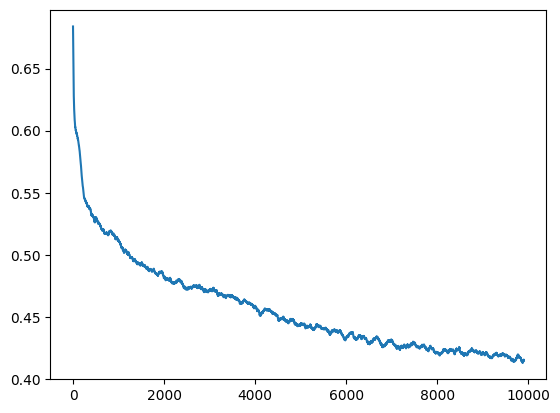

In [47]:
trainer = training_loop(loader, model, schedule, epochs=10000, lr=1e-3)
losses = [ns['loss'].item() for ns in trainer]
plt.plot(moving_average(losses, 100))

Sample from the diffusion model using 20 sampling steps, with gradient estiamtion sampler

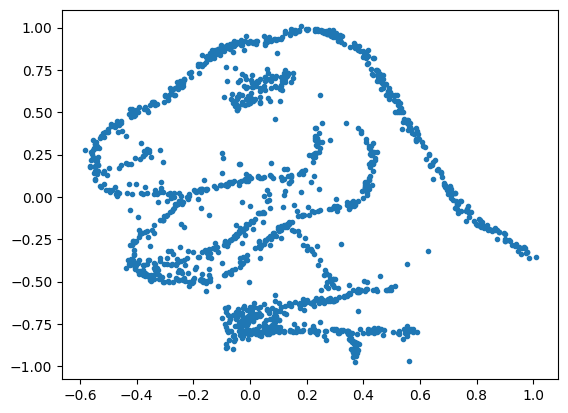

In [64]:
# For DDPM sampling, change to gam=1, mu=0.5
# For DDIM sampling, change to gam=1, mu=0
x0 = last(samples(model, schedule.sample_sigmas(20), batchsize=1500, gam=2, mu=0))
plot_batch(x0)